トレーニング: 不動産価格予想

In [45]:
DIR_PATH = "/cpt_training"

In [46]:
cd {DIR_PATH}

[Errno 2] No such file or directory: '/cpt_training'
/Users/otoya/Documents/Develop/cpt_training


In [47]:
%pip install -U "setuptools<58" # setuptoolsのverが58以上だと、xfeatの依存パッケージml-metricsのinstallに失敗するため
%pip install -q optuna xfeat japanize-matplotlib
%pip install -q optuna


[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [48]:
# import
import re

import japanize_matplotlib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
sns.set(font="IPAexGothic")

from glob import glob
from functools import partial
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from xfeat import SelectCategorical, LabelEncoder, LambdaEncoder, Pipeline, ConcatCombination, SelectNumerical, \
    ArithmeticCombinations, TargetEncoder, aggregation, GBDTFeatureSelector, GBDTFeatureExplorer
# パラメータチューニングで必要なライブラリ
import optuna
from sklearn.metrics import mean_absolute_error

In [49]:
pd.set_option('display.max_columns', None)

In [50]:
ID = 'ID'
TARGET = '取引価格（総額）_log'
time_col = '取引時点_enc'
group_col = '都道府県名'

In [51]:
BASE_PATH = './'

In [52]:
paths = glob(BASE_PATH + 'input/train/*.csv')
train_dfs = []
for path in paths:
    train_df = pd.read_csv(path)
    train_dfs.append(train_df)
train_df = pd.concat(train_dfs)
train_df.reset_index(drop=True, inplace=True)
test_df = pd.read_csv(BASE_PATH + 'input/test.csv')

# train_df, test_df, val_dfをくっつける
master_df = pd.concat([train_df, test_df])
master_df.sort_values('取引時点', inplace=True)
master_df.reset_index(drop=True, inplace=True)

/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_5793/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)
/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_5793/2232468179.py:4: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(path)


In [53]:
master_df.columns

Index(['ID', '種類', '地域', '市区町村コード', '都道府県名', '市区町村名', '地区名', '最寄駅：名称',
       '最寄駅：距離（分）', '間取り', '面積（㎡）', '土地の形状', '間口', '延床面積（㎡）', '建築年', '建物の構造',
       '用途', '今後の利用目的', '前面道路：方位', '前面道路：種類', '前面道路：幅員（ｍ）', '都市計画', '建ぺい率（％）',
       '容積率（％）', '取引時点', '改装', '取引の事情等', '取引価格（総額）_log'],
      dtype='object')

In [54]:
set(test_df['取引時点'])

{'2020年第１四半期', '2020年第２四半期'}

In [55]:
sub_df = pd.read_csv(BASE_PATH + 'input/sample_submission.csv')

In [56]:
master_df.shape

(656817, 28)

In [57]:
class Preprocessor:
    TARGET = TARGET
    group_col = group_col
    time_col = time_col

    def __init__(self, df):
        self.df = df.copy()
        self.agg_dfs = []
        self.labeling()

    @staticmethod
    def normalize_moyori(moyori):
        if moyori == moyori:
            if moyori == '30分?60分':
                moyori = 45
            elif moyori == '1H?1H30':
                moyori = 75
            elif moyori == '1H30?2H':
                moyori = 105
            elif moyori == '2H?':
                moyori = 120
            moyori = int(float(moyori))
        return moyori

    @staticmethod
    def normalize_area(area):
        if area == area:
            area = int(re.sub('m\^2未満|㎡以上', '', str(area)))
        return area

    @staticmethod
    def convert_wareki_to_seireki(wareki):
        if wareki == wareki:
            if wareki == '戦前':
                wareki = '昭和20年'
            value = wareki[2:-1]
            if value == '元':
                value = 1
            else:
                value = int(value)
            if '昭和' in wareki:
                seireki = 1925+value
            elif '平成' in wareki:
                seireki = 1988+value
            elif '令和' in wareki:
                seireki = 2018+value
        else:
            seireki = wareki
        return seireki

    @staticmethod
    def allocate(data):
        if pd.isna(data) or data == "":
            return 0
        else:
            if 'LDK' in data:
                return 1
            elif 'DK' in data:
                return 2
            elif 'K' in data:
                return 3
            elif 'フリースペース' in data:
                return 4
            else:
                return 5

    @staticmethod
    def extract_room_count(s):
        if pd.isna(s) or s == '':
            return 0
        numbers = re.findall(r'\d+', s)
        return int(numbers[0]) if numbers else 0

    def name_to_number(self):
        """取引時点を数字に変更する関数"""
        enc_dic = {}
        for i, e in enumerate(sorted(list(set(self.df['取引時点'].values)))):
            enc_dic[e] = i
        self.df['取引時点_enc'] = self.df['取引時点'].map(enc_dic)
        return self.df

    def remove_data(self):
        """全て同じ値になっていたり、すべてnullになっているものは削除する!"""
        rm_cols = [col for col in self.df.columns if self.df[col].nunique() <= 1]
        self.df.drop(columns=rm_cols, inplace=True)
        self.df.dropna(axis=1, how='all')

    def calc_mean_target(self):
        """各取引時点,都道府県での各都道府県のTARGETの平均値"""
        @staticmethod
        def calc_te(row):
            if row[self.time_col] in te_dic and row[self.group_col] in te_dic[row[self.time_col]]:
                try:
                    value = te_dic[row[self.time_col]-2][row[self.group_col]]
                except IndexError as e:
                    value = 0
                return value
            else:
                return 0
        te_dic = {}
        for i in set(self.df[self.time_col].values):
            tmp_df = self.df[self.df[self.time_col] < i]
            te_dic[i] = tmp_df.groupby(self.group_col)[TARGET].agg('mean').to_dict()
        # 最後にdfにapplyする
        self.df[self.group_col + '_te'] = self.df.apply(self.calc_te, axis=1)
        return self.df

    def get_agg_df(self):
        """group_valuesそれぞれのagg_methosを計算してくれるやつ"""
        agg_df, agg_cols = aggregation(self.df,
                            group_key=self.group_col,
                            group_values=['最寄駅：距離（分）', '容積率（％）'],
                            agg_methods=['count', 'mean', 'min', 'max'],
                            )
        return agg_df[agg_cols]

    def labeling(self):
        """データを切り取って渡してくれる"""
        self.df.sort_values('取引時点', inplace=True)
        self.df.reset_index(drop=True, inplace=True)
        self.df.loc[self.df['取引時点'].str.contains('2019年第３四半期|2019年第４四半期', regex=True), 'label'] = 1
        self.df.loc[self.df['取引時点'].str.contains('2020年第１四半期|2020年第２四半期', regex=True), 'label'] = 2
        self.df.loc[self.df['label'].isnull(), 'label'] = 0
        # self.feat_cols = [col for col in self.df.columns if col not in rm_cols+[ID, TARGET]]
        # self.df.dropna(how='any', axis=0)

    @staticmethod
    def checkStringExistence(input='', word=''):
        if not isinstance(input, str):
            return 0
        
        if word in input:
            return 1
        else:
            return 0
        
    def dummy(self, dummy_column):
        df_dummies = pd.get_dummies(self.df[dummy_column], prefix=dummy_column, drop_first=True)
        self.df = pd.concat([self.df, df_dummies], axis=1)
        self.df.drop(columns=dummy_column, axis=1)

    def fit(self):
        self.remove_data()
        self.df['取引時点_何年前'] = self.df['取引時点'].apply(lambda x: 2020-int(x[:4]))
        self.name_to_number()
        # self.df.drop(columns=['取引時点'], axis=1, inplace=True)
        self.df['部屋数'] = self.df['間取り'].apply(self.extract_room_count)
        self.df['部屋タイプ'] = self.df['間取り'].apply(lambda x: self.allocate(x))
        self.df['建築年'] = self.df['建築年'].apply(lambda x: self.convert_wareki_to_seireki(x))
        self.df['面積（㎡）'] = self.df['面積（㎡）'].apply(lambda x: self.normalize_area(x))
        self.df['最寄駅：距離（分）'] = self.df['最寄駅：距離（分）'].apply(lambda x: self.normalize_moyori(x))
        self.df['心理的瑕疵の有無'] = self.df['取引の事情等'].apply(lambda input: self.checkStringExistence(input, '瑕疵有りの可能性')) # "瑕疵有りの可能性"を別のカラムに追加、次のコードで別の列から削除
        self.df['取引の事情等'].replace({'調停・競売等、瑕疵有りの可能性': '調停・競売等',
                                   '関係者間取引、瑕疵有りの可能性': '関係者間取引',
                                   '瑕疵有りの可能性': np.nan}, inplace=True)
        self.dummy('都市計画')

    def transform(self):
        num_df = SelectNumerical().fit_transform(self.df)
        encoder = Pipeline([
            SelectCategorical(),
            LabelEncoder(output_suffix=""),
            ])
        le_df = encoder.fit_transform(self.df)
        self.agg_dfs.append(self.get_agg_df())
        self.preprocessed_df = pd.concat([num_df,le_df]+self.agg_dfs, axis=1)
        return self.preprocessed_df

In [58]:
# master_dfを処理していく
processor = Preprocessor(master_df)
processor.fit()
preprocessed_df = processor.transform()



In [59]:
# データの割り振り
train_df = preprocessed_df.loc[preprocessed_df['label']==0, :]
train_x = train_df.drop(columns=['label', TARGET])
# train_x.dropna(how='any', axis=0)
train_y = train_df[TARGET]

# データの割り振り
val_df = preprocessed_df.loc[preprocessed_df['label']==1, :]
val_x = val_df.drop(columns=['label', TARGET])
# val_x.dropna(how='any', axis=0)
val_y = val_df[TARGET]

# データの割り振り
test_df = preprocessed_df.loc[preprocessed_df['label']==2, :]
test_x = test_df.drop(columns=['label', TARGET])
# test_x.dropna(how='any', axis=0)
test_y = test_df[TARGET]

In [68]:
train_df

,ID,市区町村コード,最寄駅：距離（分）,面積（㎡）,建築年,建ぺい率（％）,容積率（％）,取引価格（総額）_log,label,取引時点_何年前,取引時点_enc,部屋数,部屋タイプ,心理的瑕疵の有無,都市計画_工業地域,都市計画_工業専用地域,都市計画_市街化区域及び市街化調整区域外の都市計画区域,都市計画_市街化調整区域,都市計画_準住居地域,都市計画_準工業地域,都市計画_準都市計画区域,都市計画_第１種中高層住居専用地域,都市計画_第１種低層住居専用地域,都市計画_第１種住居地域,都市計画_第２種中高層住居専用地域,都市計画_第２種低層住居専用地域,都市計画_第２種住居地域,都市計画_近隣商業地域,都市計画_都市計画区域外,都道府県名,市区町村名,地区名,最寄駅：名称,間取り,建物の構造,用途,今後の利用目的,都市計画,取引時点,改装,取引の事情等,agg_count_最寄駅：距離（分）_grpby_都道府県名,agg_count_容積率（％）_grpby_都道府県名,agg_mean_最寄駅：距離（分）_grpby_都道府県名,agg_mean_容積率（％）_grpby_都道府県名,agg_min_最寄駅：距離（分）_grpby_都道府県名,agg_min_容積率（％）_grpby_都道府県名,agg_max_最寄駅：距離（分）_grpby_都道府県名,agg_max_容積率（％）_grpby_都道府県名
0,13117957,13104,NaN,20,2005.0,80.0,600.0,7.342423,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,0,0,0,0,0,0,-1,0,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
1,13322502,13116,10.0,20,1992.0,80.0,400.0,7.041393,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,0,1,1,1,0,0,0,-1,1,0,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
2,13247229,13112,7.0,90,1971.0,60.0,200.0,7.623249,0.0,15,0,2,5,0,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,0,2,2,2,1,0,0,-1,2,0,-1,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
3,13279951,13113,6.0,25,1982.0,80.0,800.0,7.146128,0.0,15,0,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,3,3,3,0,0,0,-1,0,0,1,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
4,26076250,26109,8.0,50,1986.0,80.0,300.0,6.732394,0.0,15,0,0,0,0,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,1,4,4,4,-1,1,0,-1,1,0,0,-1,15009,15380,10.108735,327.955137,0.0,60.0,120.0,800.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
612438,13015116,13104,7.0,20,2004.0,60.0,200.0,7.342423,0.0,1,55,1,5,0,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,0,0,975,576,0,1,0,0,4,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
612439,13103166,13115,2.0,15,1987.0,80.0,500.0,7.113943,0.0,1,55,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,0,18,90,85,0,0,0,0,0,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0
612440,27033427,27128,2.0,25,1998.0,80.0,600.0,7.000000,0.0,1,55,1,5,0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,4,28,826,128,0,1,0,0,0,55,0,-1,72444,73162,9.253244,332.444712,0.0,80.0,120.0,1300.0
612441,13083093,13113,8.0,45,2011.0,60.0,300.0,7.672098,0.0,1,55,2,5,0,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,0,3,355,299,5,1,-1,0,3,55,0,-1,188286,192927,7.809901,353.568863,0.0,50.0,120.0,1300.0


モデル構築

In [60]:
train_set = lgb.Dataset(train_x, label=train_y)
val_set = lgb.Dataset(val_x, label=val_y)

In [61]:
def objective(trial):
  params = {
      "objective": "regression",
      "metric": "mae",
      "boosting_type": "gbdt",
      "verbosity": -1,
      "boost_from_average": "false",
      "random_seed": 42,
      "feature_pre_filter": False,
      "max_depth": trial.suggest_int('max_depth', 4, 8),
      "num_leaves": trial.suggest_int("num_leaves", 2, 100),
      "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1),
      "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
      "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
      "min_child_samples": trial.suggest_int("min_child_samples", 1, 25),
      "min_data_in_leaf": trial.suggest_int('min_data_in_leaf', 1, 4)
      }

  model = lgb.train(params, train_set, valid_sets=[val_set])

  pred_y = model.predict(val_x, num_iteration=model.best_iteration)
  mae = mean_absolute_error(val_y, pred_y)

  return mae

In [62]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2024-01-22 23:22:11,191] A new study created in memory with name: no-name-09004798-3198-4bcd-bc02-13dacced8e06


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 7.24635
[2]	valid_0's l1: 7.20626
[3]	valid_0's l1: 7.16639
[4]	valid_0's l1: 7.12675
[5]	valid_0's l1: 7.08732
[6]	valid_0's l1: 7.04804
[7]	valid_0's l1: 7.00905
[8]	valid_0's l1: 6.97025
[9]	valid_0's l1: 6.93161
[10]	valid_0's l1: 6.89332
[11]	valid_0's l1: 6.85516
[12]	valid_0's l1: 6.81732
[13]	valid_0's l1: 6.77959
[14]	valid_0's l1: 6.74206
[15]	valid_0's l1: 6.70477
[16]	valid_0's l1: 6.66767
[17]	valid_0's l1: 6.63086
[18]	valid_0's l1: 6.59416
[19]	valid_0's l1: 6.55759
[20]	valid_0's l1: 6.5213
[21]	valid_0's l1: 6.48523
[22]	valid_0's l1: 6.44936
[23]	valid_0's l1: 6.41371
[24]	valid_0's l1: 6.37825
[25]	valid_0's l1: 6.34293
[26]	valid_0's l1: 6.3078
[27]	valid_0's l1: 6.27291
[28]	valid_0's l1: 6.23824
[29]	valid_0's l1: 6.20384
[30]	valid_0's l1: 6.16954
[31]	valid_0's l1: 6.13555
[32]	valid_0's l1: 6.10169
[33]	valid_0's l1: 6.06796


[I 2024-01-22 23:22:13,352] Trial 0 finished with value: 4.188866674509489 and parameters: {'max_depth': 4, 'num_leaves': 55, 'learning_rate': 0.0055768337655670765, 'feature_fraction': 0.6675920962848584, 'bagging_fraction': 0.8303262638169143, 'min_child_samples': 11, 'min_data_in_leaf': 3}. Best is trial 0 with value: 4.188866674509489.


[86]	valid_0's l1: 4.52568
[87]	valid_0's l1: 4.50072
[88]	valid_0's l1: 4.47592
[89]	valid_0's l1: 4.45126
[90]	valid_0's l1: 4.42675
[91]	valid_0's l1: 4.40236
[92]	valid_0's l1: 4.37811
[93]	valid_0's l1: 4.35398
[94]	valid_0's l1: 4.32999
[95]	valid_0's l1: 4.30613
[96]	valid_0's l1: 4.2824
[97]	valid_0's l1: 4.25881
[98]	valid_0's l1: 4.23533
[99]	valid_0's l1: 4.21207
[100]	valid_0's l1: 4.18887
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.88443
[2]	valid_0's l1: 6.50393
[3]	valid_0's l1: 6.14531
[4]	valid_0's l1: 5.80567
[5]	valid_0's l1: 5.48485
[6]	valid_0's l1: 5.1811
[7]	valid_0's l1: 4.89533
[8]	valid_0's l1: 4.62616
[9]	valid_0's l1: 4.37086
[10]	valid_0's l1: 4.13051
[11]	valid_0's l1: 3.90282
[12]	valid_0's l1: 3.68836
[13]	valid_0's l1: 3.48523
[14]	valid_0's l1: 3.29354
[15]	valid_0's l1: 3.11251
[16]	valid_0's l1: 2.94105
[17]	valid_0's l1: 2.78033
[18]	valid_0's l1: 2.62818

[I 2024-01-22 23:22:14,231] Trial 1 finished with value: 0.13211763932647133 and parameters: {'max_depth': 4, 'num_leaves': 84, 'learning_rate': 0.05581523080252656, 'feature_fraction': 0.3824365083249875, 'bagging_fraction': 0.2830220685178069, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 1 with value: 0.13211763932647133.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 7.00563
[2]	valid_0's l1: 6.73487
[3]	valid_0's l1: 6.47596
[4]	valid_0's l1: 6.22659
[5]	valid_0's l1: 5.98656
[6]	valid_0's l1: 5.75546
[7]	valid_0's l1: 5.53372
[8]	valid_0's l1: 5.32153
[9]	valid_0's l1: 5.11657
[10]	valid_0's l1: 4.91964
[11]	valid_0's l1: 4.73031
[12]	valid_0's l1: 4.54841
[13]	valid_0's l1: 4.37315
[14]	valid_0's l1: 4.20541
[15]	valid_0's l1: 4.04352
[16]	valid_0's l1: 3.88765
[17]	valid_0's l1: 3.73817
[18]	valid_0's l1: 3.59494
[19]	valid_0's l1: 3.45672
[20]	valid_0's l1: 3.32427
[21]	valid_0's l1: 3.19644
[22]	valid_0's l1: 3.07391
[23]	valid_0's l1: 2.9565
[24]	valid_0's l1: 2.84266
[25]	valid_0's l1: 2.73327
[26]	valid_0's l1: 2.62887
[27]	valid_0's l1: 2.52814
[28]	valid_0's l1: 2.43117
[29]	valid_0's l1: 2.33796
[30]	valid_0's l1: 2.24898
[31]	valid_0's l1: 2.16291
[32]	valid_0's l1: 2.08049
[33]	valid_0's l1: 2.00106

[I 2024-01-22 23:22:16,004] Trial 2 finished with value: 0.19606465767819872 and parameters: {'max_depth': 7, 'num_leaves': 86, 'learning_rate': 0.038808032038945256, 'feature_fraction': 0.28744051617375127, 'bagging_fraction': 0.7259334754752833, 'min_child_samples': 20, 'min_data_in_leaf': 4}. Best is trial 1 with value: 0.13211763932647133.


[99]	valid_0's l1: 0.200767
[100]	valid_0's l1: 0.196065
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 7.19448
[2]	valid_0's l1: 7.10336
[3]	valid_0's l1: 7.01311
[4]	valid_0's l1: 6.9243
[5]	valid_0's l1: 6.83669
[6]	valid_0's l1: 6.74945
[7]	valid_0's l1: 6.66353
[8]	valid_0's l1: 6.57922
[9]	valid_0's l1: 6.49561
[10]	valid_0's l1: 6.41336
[11]	valid_0's l1: 6.33235
[12]	valid_0's l1: 6.25199
[13]	valid_0's l1: 6.17304
[14]	valid_0's l1: 6.09463
[15]	valid_0's l1: 6.01716
[16]	valid_0's l1: 5.94073
[17]	valid_0's l1: 5.86564
[18]	valid_0's l1: 5.79112
[19]	valid_0's l1: 5.71762
[20]	valid_0's l1: 5.64495
[21]	valid_0's l1: 5.57366
[22]	valid_0's l1: 5.50304
[23]	valid_0's l1: 5.4334
[24]	valid_0's l1: 5.3647
[25]	valid_0's l1: 5.29704
[26]	valid_0's l1: 5.22976
[27]	valid_0's l1: 5.16388
[28]	valid_0's l1: 5.09867
[29]	valid_0's l1: 5.03399
[30]	valid_0's l1: 4.97022
[31]	valid_0's l1: 4.9072

[I 2024-01-22 23:22:16,796] Trial 3 finished with value: 2.0488090779969808 and parameters: {'max_depth': 5, 'num_leaves': 17, 'learning_rate': 0.012783938068789736, 'feature_fraction': 0.15183538303541586, 'bagging_fraction': 0.15811217170010425, 'min_child_samples': 2, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.13211763932647133.


[99]	valid_0's l1: 2.07497
[100]	valid_0's l1: 2.04881
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 7.26836
[2]	valid_0's l1: 7.25009
[3]	valid_0's l1: 7.23187
[4]	valid_0's l1: 7.21366
[5]	valid_0's l1: 7.19546
[6]	valid_0's l1: 7.1773
[7]	valid_0's l1: 7.15926
[8]	valid_0's l1: 7.14126
[9]	valid_0's l1: 7.12324
[10]	valid_0's l1: 7.10532
[11]	valid_0's l1: 7.08739
[12]	valid_0's l1: 7.06957
[13]	valid_0's l1: 7.05174
[14]	valid_0's l1: 7.03394
[15]	valid_0's l1: 7.0162
[16]	valid_0's l1: 6.9985
[17]	valid_0's l1: 6.9809
[18]	valid_0's l1: 6.96334
[19]	valid_0's l1: 6.94577
[20]	valid_0's l1: 6.92824
[21]	valid_0's l1: 6.91076
[22]	valid_0's l1: 6.89337
[23]	valid_0's l1: 6.87603
[24]	valid_0's l1: 6.8587
[25]	valid_0's l1: 6.8414
[26]	valid_0's l1: 6.82414
[27]	valid_0's l1: 6.80693
[28]	valid_0's l1: 6.78976
[29]	valid_0's l1: 6.77268
[30]	valid_0's l1: 6.7556
[31]	valid_0's l1: 6.73863
[32]

[I 2024-01-22 23:22:17,558] Trial 4 finished with value: 5.663076441233194 and parameters: {'max_depth': 6, 'num_leaves': 5, 'learning_rate': 0.0025426329710420918, 'feature_fraction': 0.5102643452159593, 'bagging_fraction': 0.977351561955346, 'min_child_samples': 6, 'min_data_in_leaf': 3}. Best is trial 1 with value: 0.13211763932647133.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.68048
[2]	valid_0's l1: 6.12398
[3]	valid_0's l1: 5.61632
[4]	valid_0's l1: 5.14969
[5]	valid_0's l1: 4.72168
[6]	valid_0's l1: 4.3286
[7]	valid_0's l1: 3.96973
[8]	valid_0's l1: 3.64125
[9]	valid_0's l1: 3.33881
[10]	valid_0's l1: 3.06296
[11]	valid_0's l1: 2.80909
[12]	valid_0's l1: 2.57681
[13]	valid_0's l1: 2.36367
[14]	valid_0's l1: 2.16825
[15]	valid_0's l1: 1.98938
[16]	valid_0's l1: 1.82526
[17]	valid_0's l1: 1.67525
[18]	valid_0's l1: 1.53754
[19]	valid_0's l1: 1.4104
[20]	valid_0's l1: 1.29478
[21]	valid_0's l1: 1.18913
[22]	valid_0's l1: 1.09183
[23]	valid_0's l1: 1.00363
[24]	valid_0's l1: 0.921776
[25]	valid_0's l1: 0.847057
[26]	valid_0's l1: 0.779153
[27]	valid_0's l1: 0.716984
[28]	valid_0's l1: 0.660221
[29]	valid_0's l1: 0.608716
[30]	valid_0's l1: 0.561389
[31]	valid_0's l1: 0.518276
[32]	valid_0's l1: 0.478449
[33]	valid_0's l1:

[I 2024-01-22 23:22:19,164] Trial 5 finished with value: 0.10604806326605998 and parameters: {'max_depth': 7, 'num_leaves': 48, 'learning_rate': 0.08387348441214248, 'feature_fraction': 0.4875797141646111, 'bagging_fraction': 0.6187917586125281, 'min_child_samples': 24, 'min_data_in_leaf': 2}. Best is trial 5 with value: 0.10604806326605998.


[94]	valid_0's l1: 0.107017
[95]	valid_0's l1: 0.106888
[96]	valid_0's l1: 0.106718
[97]	valid_0's l1: 0.106594
[98]	valid_0's l1: 0.106388
[99]	valid_0's l1: 0.106185
[100]	valid_0's l1: 0.106048
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.87699
[2]	valid_0's l1: 6.49042
[3]	valid_0's l1: 6.12633
[4]	valid_0's l1: 5.7817
[5]	valid_0's l1: 5.45647
[6]	valid_0's l1: 5.14913
[7]	valid_0's l1: 4.85946
[8]	valid_0's l1: 4.58659
[9]	valid_0's l1: 4.3284
[10]	valid_0's l1: 4.08551
[11]	valid_0's l1: 3.85601
[12]	valid_0's l1: 3.6399
[13]	valid_0's l1: 3.43541
[14]	valid_0's l1: 3.24253
[15]	valid_0's l1: 3.06082
[16]	valid_0's l1: 2.88912
[17]	valid_0's l1: 2.72747
[18]	valid_0's l1: 2.57511
[19]	valid_0's l1: 2.43061
[20]	valid_0's l1: 2.29459
[21]	valid_0's l1: 2.16646
[22]	valid_0's l1: 2.04506
[23]	valid_0's l1: 1.9314
[24]	valid_0's l1: 1.82355
[25]	valid_0's l1: 1.72183
[26]	valid_0's l1: 1.

[I 2024-01-22 23:22:21,237] Trial 6 finished with value: 0.11416410800079829 and parameters: {'max_depth': 7, 'num_leaves': 98, 'learning_rate': 0.05667418890323691, 'feature_fraction': 0.5416445916607004, 'bagging_fraction': 0.8709922527701406, 'min_child_samples': 19, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.10604806326605998.


[97]	valid_0's l1: 0.116136
[98]	valid_0's l1: 0.115496
[99]	valid_0's l1: 0.114848
[100]	valid_0's l1: 0.114164
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.78437
[2]	valid_0's l1: 6.31682
[3]	valid_0's l1: 5.88237
[4]	valid_0's l1: 5.47712
[5]	valid_0's l1: 5.09955
[6]	valid_0's l1: 4.74744
[7]	valid_0's l1: 4.42108
[8]	valid_0's l1: 4.11774
[9]	valid_0's l1: 3.83436
[10]	valid_0's l1: 3.57166
[11]	valid_0's l1: 3.3264
[12]	valid_0's l1: 3.09865
[13]	valid_0's l1: 2.88584
[14]	valid_0's l1: 2.6883
[15]	valid_0's l1: 2.50445
[16]	valid_0's l1: 2.33318
[17]	valid_0's l1: 2.17425
[18]	valid_0's l1: 2.0266
[19]	valid_0's l1: 1.88822
[20]	valid_0's l1: 1.75995
[21]	valid_0's l1: 1.64073
[22]	valid_0's l1: 1.52928
[23]	valid_0's l1: 1.4263
[24]	valid_0's l1: 1.32944
[25]	valid_0's l1: 1.23965
[26]	valid_0's l1: 1.15631
[27]	valid_0's l1: 1.07913
[28]	valid_0's l1: 1.00716
[29]	valid_0's l1: 0.940

[I 2024-01-22 23:22:22,171] Trial 7 finished with value: 0.12168845607397459 and parameters: {'max_depth': 4, 'num_leaves': 42, 'learning_rate': 0.06962822392897396, 'feature_fraction': 0.5185756295813396, 'bagging_fraction': 0.39065858548030585, 'min_child_samples': 24, 'min_data_in_leaf': 4}. Best is trial 5 with value: 0.10604806326605998.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.62959
[2]	valid_0's l1: 6.03221
[3]	valid_0's l1: 5.48958
[4]	valid_0's l1: 4.99536
[5]	valid_0's l1: 4.54658
[6]	valid_0's l1: 4.13864
[7]	valid_0's l1: 3.76728
[8]	valid_0's l1: 3.42982
[9]	valid_0's l1: 3.12275
[10]	valid_0's l1: 2.8434
[11]	valid_0's l1: 2.58945
[12]	valid_0's l1: 2.35859
[13]	valid_0's l1: 2.14924
[14]	valid_0's l1: 1.9584
[15]	valid_0's l1: 1.78506
[16]	valid_0's l1: 1.62688
[17]	valid_0's l1: 1.48383
[18]	valid_0's l1: 1.35324
[19]	valid_0's l1: 1.23486
[20]	valid_0's l1: 1.12665
[21]	valid_0's l1: 1.02904
[22]	valid_0's l1: 0.940208
[23]	valid_0's l1: 0.858945
[24]	valid_0's l1: 0.786164
[25]	valid_0's l1: 0.720275
[26]	valid_0's l1: 0.66015
[27]	valid_0's l1: 0.605009
[28]	valid_0's l1: 0.554802
[29]	valid_0's l1: 0.50972
[30]	valid_0's l1: 0.467498
[31]	valid_0's l1: 0.429511
[32]	valid_0's l1: 0.396562
[33]	valid_0's l1:

[I 2024-01-22 23:22:23,083] Trial 8 finished with value: 0.11543524591249946 and parameters: {'max_depth': 4, 'num_leaves': 41, 'learning_rate': 0.09082112981713893, 'feature_fraction': 0.8693067868612658, 'bagging_fraction': 0.9865501914647439, 'min_child_samples': 13, 'min_data_in_leaf': 3}. Best is trial 5 with value: 0.10604806326605998.


[93]	valid_0's l1: 0.116492
[94]	valid_0's l1: 0.116325
[95]	valid_0's l1: 0.116218
[96]	valid_0's l1: 0.115928
[97]	valid_0's l1: 0.115764
[98]	valid_0's l1: 0.115662
[99]	valid_0's l1: 0.115594
[100]	valid_0's l1: 0.115435
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 7.23119
[2]	valid_0's l1: 7.17611
[3]	valid_0's l1: 7.12145
[4]	valid_0's l1: 7.06717
[5]	valid_0's l1: 7.01335
[6]	valid_0's l1: 6.95993
[7]	valid_0's l1: 6.90694
[8]	valid_0's l1: 6.85434
[9]	valid_0's l1: 6.80216
[10]	valid_0's l1: 6.75038
[11]	valid_0's l1: 6.699
[12]	valid_0's l1: 6.64811
[13]	valid_0's l1: 6.59753
[14]	valid_0's l1: 6.5473
[15]	valid_0's l1: 6.49741
[16]	valid_0's l1: 6.44795
[17]	valid_0's l1: 6.39889
[18]	valid_0's l1: 6.35019
[19]	valid_0's l1: 6.30189
[20]	valid_0's l1: 6.25395
[21]	valid_0's l1: 6.20635
[22]	valid_0's l1: 6.15912
[23]	valid_0's l1: 6.11227
[24]	valid_0's l1: 6.06577
[25]	valid_0's l1: 

[I 2024-01-22 23:22:24,796] Trial 9 finished with value: 3.399349733514187 and parameters: {'max_depth': 6, 'num_leaves': 53, 'learning_rate': 0.007664852943268499, 'feature_fraction': 0.8914191883980401, 'bagging_fraction': 0.8702829355205585, 'min_child_samples': 3, 'min_data_in_leaf': 1}. Best is trial 5 with value: 0.10604806326605998.


[96]	valid_0's l1: 3.50426
[97]	valid_0's l1: 3.47773
[98]	valid_0's l1: 3.45141
[99]	valid_0's l1: 3.42529
[100]	valid_0's l1: 3.39935
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59451
[2]	valid_0's l1: 5.96879
[3]	valid_0's l1: 5.40327
[4]	valid_0's l1: 4.89168
[5]	valid_0's l1: 4.4287
[6]	valid_0's l1: 4.00929
[7]	valid_0's l1: 3.63053
[8]	valid_0's l1: 3.28796
[9]	valid_0's l1: 2.97784
[10]	valid_0's l1: 2.69795
[11]	valid_0's l1: 2.44433
[12]	valid_0's l1: 2.21484
[13]	valid_0's l1: 2.00657
[14]	valid_0's l1: 1.81882
[15]	valid_0's l1: 1.64795
[16]	valid_0's l1: 1.49455
[17]	valid_0's l1: 1.35482
[18]	valid_0's l1: 1.22915
[19]	valid_0's l1: 1.11411
[20]	valid_0's l1: 1.01158
[21]	valid_0's l1: 0.918652
[22]	valid_0's l1: 0.833511
[23]	valid_0's l1: 0.757765
[24]	valid_0's l1: 0.688932
[25]	valid_0's l1: 0.626738
[26]	valid_0's l1: 0.57134
[27]	valid_0's l1: 0.521208
[28]	valid_0's l1: 

[I 2024-01-22 23:22:26,154] Trial 10 finished with value: 0.10524508662791432 and parameters: {'max_depth': 8, 'num_leaves': 30, 'learning_rate': 0.09563605411725888, 'feature_fraction': 0.6974802886673803, 'bagging_fraction': 0.5821558410514109, 'min_child_samples': 17, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.10524508662791432.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60365
[2]	valid_0's l1: 5.98527
[3]	valid_0's l1: 5.4257
[4]	valid_0's l1: 4.91793
[5]	valid_0's l1: 4.45859
[6]	valid_0's l1: 4.04239
[7]	valid_0's l1: 3.66567
[8]	valid_0's l1: 3.32424
[9]	valid_0's l1: 3.01473
[10]	valid_0's l1: 2.73493
[11]	valid_0's l1: 2.48129
[12]	valid_0's l1: 2.25116
[13]	valid_0's l1: 2.04249
[14]	valid_0's l1: 1.85363
[15]	valid_0's l1: 1.68202
[16]	valid_0's l1: 1.5269
[17]	valid_0's l1: 1.38658
[18]	valid_0's l1: 1.2598
[19]	valid_0's l1: 1.14431
[20]	valid_0's l1: 1.03968
[21]	valid_0's l1: 0.945734
[22]	valid_0's l1: 0.85939
[23]	valid_0's l1: 0.78288
[24]	valid_0's l1: 0.713137
[25]	valid_0's l1: 0.648971
[26]	valid_0's l1: 0.591723
[27]	valid_0's l1: 0.540394
[28]	valid_0's l1: 0.493442
[29]	valid_0's l1: 0.452398
[30]	valid_0's l1: 0.414394
[31]	valid_0's l1: 0.37956
[32]	valid_0's l1: 0.349376
[33]	valid_0's l1: 

[I 2024-01-22 23:22:27,491] Trial 11 finished with value: 0.10591539027544948 and parameters: {'max_depth': 8, 'num_leaves': 29, 'learning_rate': 0.0943767064396444, 'feature_fraction': 0.7158221865710942, 'bagging_fraction': 0.5695726250127465, 'min_child_samples': 18, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.10524508662791432.


[98]	valid_0's l1: 0.106726
[99]	valid_0's l1: 0.106353
[100]	valid_0's l1: 0.105915
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57898
[2]	valid_0's l1: 5.94046
[3]	valid_0's l1: 5.36446
[4]	valid_0's l1: 4.84426
[5]	valid_0's l1: 4.3754
[6]	valid_0's l1: 3.95212
[7]	valid_0's l1: 3.57059
[8]	valid_0's l1: 3.22611
[9]	valid_0's l1: 2.91532
[10]	valid_0's l1: 2.63547
[11]	valid_0's l1: 2.38205
[12]	valid_0's l1: 2.15378
[13]	valid_0's l1: 1.94764
[14]	valid_0's l1: 1.76165
[15]	valid_0's l1: 1.59254
[16]	valid_0's l1: 1.44077
[17]	valid_0's l1: 1.30387
[18]	valid_0's l1: 1.18068
[19]	valid_0's l1: 1.06846
[20]	valid_0's l1: 0.967914
[21]	valid_0's l1: 0.877558
[22]	valid_0's l1: 0.795608
[23]	valid_0's l1: 0.721765
[24]	valid_0's l1: 0.655594
[25]	valid_0's l1: 0.59494
[26]	valid_0's l1: 0.541234
[27]	valid_0's l1: 0.493303
[28]	valid_0's l1: 0.449595
[29]	valid_0's l1: 0.41137
[30]	valid_0's

[I 2024-01-22 23:22:28,743] Trial 12 finished with value: 0.10723441425318445 and parameters: {'max_depth': 8, 'num_leaves': 24, 'learning_rate': 0.09783674535184081, 'feature_fraction': 0.7146878451752763, 'bagging_fraction': 0.5402662490338469, 'min_child_samples': 17, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.10524508662791432.


[97]	valid_0's l1: 0.10778
[98]	valid_0's l1: 0.107688
[99]	valid_0's l1: 0.107535
[100]	valid_0's l1: 0.107234
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58171
[2]	valid_0's l1: 5.94562
[3]	valid_0's l1: 5.37194
[4]	valid_0's l1: 4.85311
[5]	valid_0's l1: 4.38534
[6]	valid_0's l1: 3.96305
[7]	valid_0's l1: 3.58218
[8]	valid_0's l1: 3.23799
[9]	valid_0's l1: 2.92691
[10]	valid_0's l1: 2.64646
[11]	valid_0's l1: 2.39264
[12]	valid_0's l1: 2.16363
[13]	valid_0's l1: 1.95694
[14]	valid_0's l1: 1.77073
[15]	valid_0's l1: 1.60129
[16]	valid_0's l1: 1.44923
[17]	valid_0's l1: 1.31167
[18]	valid_0's l1: 1.1877
[19]	valid_0's l1: 1.07556
[20]	valid_0's l1: 0.974256
[21]	valid_0's l1: 0.88355
[22]	valid_0's l1: 0.801034
[23]	valid_0's l1: 0.72769
[24]	valid_0's l1: 0.661195
[25]	valid_0's l1: 0.600207
[26]	valid_0's l1: 0.546158
[27]	valid_0's l1: 0.497371
[28]	valid_0's l1: 0.452535
[29]	valid_0's 

[I 2024-01-22 23:22:30,163] Trial 13 finished with value: 0.10577890120133879 and parameters: {'max_depth': 8, 'num_leaves': 29, 'learning_rate': 0.0974073215232458, 'feature_fraction': 0.7244691815801643, 'bagging_fraction': 0.5283728878115567, 'min_child_samples': 16, 'min_data_in_leaf': 1}. Best is trial 10 with value: 0.10524508662791432.


[100]	valid_0's l1: 0.105779
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.72954
[2]	valid_0's l1: 6.21528
[3]	valid_0's l1: 5.74079
[4]	valid_0's l1: 5.30258
[5]	valid_0's l1: 4.8982
[6]	valid_0's l1: 4.52476
[7]	valid_0's l1: 4.1803
[8]	valid_0's l1: 3.86214
[9]	valid_0's l1: 3.56945
[10]	valid_0's l1: 3.29977
[11]	valid_0's l1: 3.04967
[12]	valid_0's l1: 2.81953
[13]	valid_0's l1: 2.6076
[14]	valid_0's l1: 2.41047
[15]	valid_0's l1: 2.22996
[16]	valid_0's l1: 2.06298
[17]	valid_0's l1: 1.90922
[18]	valid_0's l1: 1.76681
[19]	valid_0's l1: 1.63467
[20]	valid_0's l1: 1.51399
[21]	valid_0's l1: 1.40217
[22]	valid_0's l1: 1.29951
[23]	valid_0's l1: 1.20467
[24]	valid_0's l1: 1.11762
[25]	valid_0's l1: 1.03624
[26]	valid_0's l1: 0.962014
[27]	valid_0's l1: 0.893984
[28]	valid_0's l1: 0.831178
[29]	valid_0's l1: 0.773866
[30]	valid_0's l1: 0.720548
[31]	valid_0's l1: 0.6722
[32]	valid_0's l1: 0.6

[I 2024-01-22 23:22:30,614] Trial 14 finished with value: 0.1676032864353947 and parameters: {'max_depth': 8, 'num_leaves': 2, 'learning_rate': 0.0770136109306874, 'feature_fraction': 0.9943062552051771, 'bagging_fraction': 0.4569610527698832, 'min_child_samples': 15, 'min_data_in_leaf': 2}. Best is trial 10 with value: 0.10524508662791432.


[81]	valid_0's l1: 0.1775
[82]	valid_0's l1: 0.176559
[83]	valid_0's l1: 0.176149
[84]	valid_0's l1: 0.175324
[85]	valid_0's l1: 0.17496
[86]	valid_0's l1: 0.173735
[87]	valid_0's l1: 0.173401
[88]	valid_0's l1: 0.172662
[89]	valid_0's l1: 0.172293
[90]	valid_0's l1: 0.171568
[91]	valid_0's l1: 0.171073
[92]	valid_0's l1: 0.170622
[93]	valid_0's l1: 0.170397
[94]	valid_0's l1: 0.169607
[95]	valid_0's l1: 0.169188
[96]	valid_0's l1: 0.168997
[97]	valid_0's l1: 0.168663
[98]	valid_0's l1: 0.168126
[99]	valid_0's l1: 0.167957
[100]	valid_0's l1: 0.167603
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56436
[2]	valid_0's l1: 5.91298
[3]	valid_0's l1: 5.3269
[4]	valid_0's l1: 4.79951
[5]	valid_0's l1: 4.3241
[6]	valid_0's l1: 3.89605
[7]	valid_0's l1: 3.51091
[8]	valid_0's l1: 3.16422
[9]	valid_0's l1: 2.8519
[10]	valid_0's l1: 2.57001
[11]	valid_0's l1: 2.31675
[12]	valid_0's l1: 2.08867
[13]	valid

[I 2024-01-22 23:22:32,630] Trial 15 finished with value: 0.09973459570527898 and parameters: {'max_depth': 8, 'num_leaves': 68, 'learning_rate': 0.09989315262922965, 'feature_fraction': 0.6366416868645656, 'bagging_fraction': 0.6732836895385361, 'min_child_samples': 21, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.09973459570527898.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.69511
[2]	valid_0's l1: 6.15073
[3]	valid_0's l1: 5.65135
[4]	valid_0's l1: 5.19301
[5]	valid_0's l1: 4.77151
[6]	valid_0's l1: 4.38392
[7]	valid_0's l1: 4.02861
[8]	valid_0's l1: 3.70218
[9]	valid_0's l1: 3.4021
[10]	valid_0's l1: 3.1266
[11]	valid_0's l1: 2.8737
[12]	valid_0's l1: 2.64146
[13]	valid_0's l1: 2.42818
[14]	valid_0's l1: 2.23227
[15]	valid_0's l1: 2.05197
[16]	valid_0's l1: 1.88715
[17]	valid_0's l1: 1.73546
[18]	valid_0's l1: 1.59631
[19]	valid_0's l1: 1.46773
[20]	valid_0's l1: 1.35044
[21]	valid_0's l1: 1.2426
[22]	valid_0's l1: 1.14338
[23]	valid_0's l1: 1.05249
[24]	valid_0's l1: 0.968753
[25]	valid_0's l1: 0.892415
[26]	valid_0's l1: 0.822381
[27]	valid_0's l1: 0.758082
[28]	valid_0's l1: 0.698419
[29]	valid_0's l1: 0.6444
[30]	valid_0's l1: 0.594882
[31]	valid_0's l1: 0.549913
[32]	valid_0's l1: 0.508576
[33]	valid_0's l1: 0.4

[I 2024-01-22 23:22:34,493] Trial 16 finished with value: 0.10351281095290807 and parameters: {'max_depth': 7, 'num_leaves': 71, 'learning_rate': 0.08181620406190675, 'feature_fraction': 0.6081934505619956, 'bagging_fraction': 0.6612622954264883, 'min_child_samples': 21, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.09973459570527898.


[93]	valid_0's l1: 0.104627
[94]	valid_0's l1: 0.104494
[95]	valid_0's l1: 0.104382
[96]	valid_0's l1: 0.104163
[97]	valid_0's l1: 0.104009
[98]	valid_0's l1: 0.103884
[99]	valid_0's l1: 0.103714
[100]	valid_0's l1: 0.103513
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.71082
[2]	valid_0's l1: 6.17949
[3]	valid_0's l1: 5.69095
[4]	valid_0's l1: 5.24143
[5]	valid_0's l1: 4.8273
[6]	valid_0's l1: 4.44538
[7]	valid_0's l1: 4.0944
[8]	valid_0's l1: 3.77171
[9]	valid_0's l1: 3.47397
[10]	valid_0's l1: 3.20001
[11]	valid_0's l1: 2.94795
[12]	valid_0's l1: 2.71589
[13]	valid_0's l1: 2.5021
[14]	valid_0's l1: 2.30546
[15]	valid_0's l1: 2.12405
[16]	valid_0's l1: 1.95746
[17]	valid_0's l1: 1.804
[18]	valid_0's l1: 1.66303
[19]	valid_0's l1: 1.53226
[20]	valid_0's l1: 1.41285
[21]	valid_0's l1: 1.30296
[22]	valid_0's l1: 1.20147
[23]	valid_0's l1: 1.10805
[24]	valid_0's l1: 1.02228
[25]	valid_0's l1: 0.

[I 2024-01-22 23:22:36,322] Trial 17 finished with value: 0.10439806795244216 and parameters: {'max_depth': 7, 'num_leaves': 68, 'learning_rate': 0.07967283835891714, 'feature_fraction': 0.6016499192123779, 'bagging_fraction': 0.7018806534296989, 'min_child_samples': 22, 'min_data_in_leaf': 2}. Best is trial 15 with value: 0.09973459570527898.


[100]	valid_0's l1: 0.104398
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.76271
[2]	valid_0's l1: 6.27561
[3]	valid_0's l1: 5.82575
[4]	valid_0's l1: 5.40712
[5]	valid_0's l1: 5.01818
[6]	valid_0's l1: 4.65677
[7]	valid_0's l1: 4.3221
[8]	valid_0's l1: 4.01321
[9]	valid_0's l1: 3.7248
[10]	valid_0's l1: 3.4578
[11]	valid_0's l1: 3.20978
[12]	valid_0's l1: 2.97997
[13]	valid_0's l1: 2.76615
[14]	valid_0's l1: 2.56813
[15]	valid_0's l1: 2.38458
[16]	valid_0's l1: 2.2134
[17]	valid_0's l1: 2.05561
[18]	valid_0's l1: 1.90894
[19]	valid_0's l1: 1.7721
[20]	valid_0's l1: 1.64593
[21]	valid_0's l1: 1.52871
[22]	valid_0's l1: 1.41961
[23]	valid_0's l1: 1.31952
[24]	valid_0's l1: 1.22589
[25]	valid_0's l1: 1.13875
[26]	valid_0's l1: 1.05881
[27]	valid_0's l1: 0.984286
[28]	valid_0's l1: 0.915512
[29]	valid_0's l1: 0.852203
[30]	valid_0's l1: 0.793159
[31]	valid_0's l1: 0.738064
[32]	valid_0's l1: 0.68

[I 2024-01-22 23:22:38,032] Trial 18 finished with value: 0.10707509498576341 and parameters: {'max_depth': 7, 'num_leaves': 67, 'learning_rate': 0.07250328701741443, 'feature_fraction': 0.4006719104499571, 'bagging_fraction': 0.6906262671287827, 'min_child_samples': 21, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.09973459570527898.


[98]	valid_0's l1: 0.107646
[99]	valid_0's l1: 0.107436
[100]	valid_0's l1: 0.107075
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.66172
[2]	valid_0's l1: 6.08969
[3]	valid_0's l1: 5.56725
[4]	valid_0's l1: 5.09001
[5]	valid_0's l1: 4.65356
[6]	valid_0's l1: 4.25426
[7]	valid_0's l1: 3.8902
[8]	valid_0's l1: 3.55734
[9]	valid_0's l1: 3.25312
[10]	valid_0's l1: 2.97606
[11]	valid_0's l1: 2.72229
[12]	valid_0's l1: 2.49025
[13]	valid_0's l1: 2.27826
[14]	valid_0's l1: 2.08425
[15]	valid_0's l1: 1.90684
[16]	valid_0's l1: 1.74535
[17]	valid_0's l1: 1.59787
[18]	valid_0's l1: 1.4628
[19]	valid_0's l1: 1.3386
[20]	valid_0's l1: 1.22596
[21]	valid_0's l1: 1.12331
[22]	valid_0's l1: 1.029
[23]	valid_0's l1: 0.943172
[24]	valid_0's l1: 0.864567
[25]	valid_0's l1: 0.793215
[26]	valid_0's l1: 0.728279
[27]	valid_0's l1: 0.668621
[28]	valid_0's l1: 0.613805
[29]	valid_0's l1: 0.564505
[30]	valid_0's l1: 

[I 2024-01-22 23:22:39,546] Trial 19 finished with value: 0.10533245321242216 and parameters: {'max_depth': 6, 'num_leaves': 69, 'learning_rate': 0.08643074615299204, 'feature_fraction': 0.6064057100566346, 'bagging_fraction': 0.7363084928918425, 'min_child_samples': 25, 'min_data_in_leaf': 2}. Best is trial 15 with value: 0.09973459570527898.


[93]	valid_0's l1: 0.106501
[94]	valid_0's l1: 0.106391
[95]	valid_0's l1: 0.106223
[96]	valid_0's l1: 0.105876
[97]	valid_0's l1: 0.105712
[98]	valid_0's l1: 0.10553
[99]	valid_0's l1: 0.105424
[100]	valid_0's l1: 0.105332
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.66203
[2]	valid_0's l1: 6.08983
[3]	valid_0's l1: 5.56728
[4]	valid_0's l1: 5.09048
[5]	valid_0's l1: 4.65431
[6]	valid_0's l1: 4.25492
[7]	valid_0's l1: 3.89068
[8]	valid_0's l1: 3.55796
[9]	valid_0's l1: 3.25437
[10]	valid_0's l1: 2.9775
[11]	valid_0's l1: 2.72384
[12]	valid_0's l1: 2.49239
[13]	valid_0's l1: 2.28063
[14]	valid_0's l1: 2.08708
[15]	valid_0's l1: 1.90963
[16]	valid_0's l1: 1.74827
[17]	valid_0's l1: 1.60098
[18]	valid_0's l1: 1.46612
[19]	valid_0's l1: 1.34201
[20]	valid_0's l1: 1.22971
[21]	valid_0's l1: 1.12716
[22]	valid_0's l1: 1.0328
[23]	valid_0's l1: 0.947296
[24]	valid_0's l1: 0.868518
[25]	valid_0's l1

[I 2024-01-22 23:22:40,703] Trial 20 finished with value: 0.1108186054520714 and parameters: {'max_depth': 5, 'num_leaves': 81, 'learning_rate': 0.08653285038295976, 'feature_fraction': 0.6079727050665638, 'bagging_fraction': 0.6395812396680175, 'min_child_samples': 22, 'min_data_in_leaf': 1}. Best is trial 15 with value: 0.09973459570527898.


[98]	valid_0's l1: 0.111334
[99]	valid_0's l1: 0.111029
[100]	valid_0's l1: 0.110819
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.69649
[2]	valid_0's l1: 6.15332
[3]	valid_0's l1: 5.65492
[4]	valid_0's l1: 5.1973
[5]	valid_0's l1: 4.77645
[6]	valid_0's l1: 4.38927
[7]	valid_0's l1: 4.03433
[8]	valid_0's l1: 3.70833
[9]	valid_0's l1: 3.40843
[10]	valid_0's l1: 3.13307
[11]	valid_0's l1: 2.88024
[12]	valid_0's l1: 2.64802
[13]	valid_0's l1: 2.43472
[14]	valid_0's l1: 2.23875
[15]	valid_0's l1: 2.05838
[16]	valid_0's l1: 1.89341
[17]	valid_0's l1: 1.74161
[18]	valid_0's l1: 1.60216
[19]	valid_0's l1: 1.47318
[20]	valid_0's l1: 1.35576
[21]	valid_0's l1: 1.24787
[22]	valid_0's l1: 1.14848
[23]	valid_0's l1: 1.05741
[24]	valid_0's l1: 0.973511
[25]	valid_0's l1: 0.89688
[26]	valid_0's l1: 0.826731
[27]	valid_0's l1: 0.762123
[28]	valid_0's l1: 0.702395
[29]	valid_0's l1: 0.64822
[30]	valid_0's l1:

[I 2024-01-22 23:22:42,569] Trial 21 finished with value: 0.10328945017782479 and parameters: {'max_depth': 7, 'num_leaves': 72, 'learning_rate': 0.08162076327614425, 'feature_fraction': 0.6133644936228743, 'bagging_fraction': 0.7624680339233678, 'min_child_samples': 21, 'min_data_in_leaf': 2}. Best is trial 15 with value: 0.09973459570527898.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56304
[2]	valid_0's l1: 5.91162
[3]	valid_0's l1: 5.32576
[4]	valid_0's l1: 4.79789
[5]	valid_0's l1: 4.32309
[6]	valid_0's l1: 3.89516
[7]	valid_0's l1: 3.5101
[8]	valid_0's l1: 3.16332
[9]	valid_0's l1: 2.85107
[10]	valid_0's l1: 2.56958
[11]	valid_0's l1: 2.31673
[12]	valid_0's l1: 2.08861
[13]	valid_0's l1: 1.88344
[14]	valid_0's l1: 1.69869
[15]	valid_0's l1: 1.53184
[16]	valid_0's l1: 1.38218
[17]	valid_0's l1: 1.24681
[18]	valid_0's l1: 1.12537
[19]	valid_0's l1: 1.01549
[20]	valid_0's l1: 0.917523
[21]	valid_0's l1: 0.829784
[22]	valid_0's l1: 0.750423
[23]	valid_0's l1: 0.679077
[24]	valid_0's l1: 0.615136
[25]	valid_0's l1: 0.556826
[26]	valid_0's l1: 0.505291
[27]	valid_0's l1: 0.459013
[28]	valid_0's l1: 0.417099
[29]	valid_0's l1: 0.380502
[30]	valid_0's l1: 0.347213
[31]	valid_0's l1: 0.317568
[32]	valid_0's l1: 0.291852
[33]	valid_0'

[I 2024-01-22 23:22:44,406] Trial 22 finished with value: 0.09990666697762435 and parameters: {'max_depth': 7, 'num_leaves': 75, 'learning_rate': 0.09988617602931654, 'feature_fraction': 0.7760525255030516, 'bagging_fraction': 0.7656398986605597, 'min_child_samples': 14, 'min_data_in_leaf': 2}. Best is trial 15 with value: 0.09973459570527898.


[96]	valid_0's l1: 0.100588
[97]	valid_0's l1: 0.10032
[98]	valid_0's l1: 0.100118
[99]	valid_0's l1: 0.0999914
[100]	valid_0's l1: 0.0999067
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56789
[2]	valid_0's l1: 5.9207
[3]	valid_0's l1: 5.33783
[4]	valid_0's l1: 4.8122
[5]	valid_0's l1: 4.33914
[6]	valid_0's l1: 3.91248
[7]	valid_0's l1: 3.52875
[8]	valid_0's l1: 3.18237
[9]	valid_0's l1: 2.8705
[10]	valid_0's l1: 2.58951
[11]	valid_0's l1: 2.33632
[12]	valid_0's l1: 2.10785
[13]	valid_0's l1: 1.90257
[14]	valid_0's l1: 1.71702
[15]	valid_0's l1: 1.54955
[16]	valid_0's l1: 1.39941
[17]	valid_0's l1: 1.26443
[18]	valid_0's l1: 1.1422
[19]	valid_0's l1: 1.03226
[20]	valid_0's l1: 0.933478
[21]	valid_0's l1: 0.844656
[22]	valid_0's l1: 0.764637
[23]	valid_0's l1: 0.69276
[24]	valid_0's l1: 0.628204
[25]	valid_0's l1: 0.56925
[26]	valid_0's l1: 0.516637
[27]	valid_0's l1: 0.470114
[28]	valid_0's l

[I 2024-01-22 23:22:45,943] Trial 23 finished with value: 0.10380063817422192 and parameters: {'max_depth': 6, 'num_leaves': 60, 'learning_rate': 0.09924041268286968, 'feature_fraction': 0.7927150579361669, 'bagging_fraction': 0.7787567444420523, 'min_child_samples': 14, 'min_data_in_leaf': 2}. Best is trial 15 with value: 0.09973459570527898.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.63101
[2]	valid_0's l1: 6.0348
[3]	valid_0's l1: 5.4926
[4]	valid_0's l1: 4.99892
[5]	valid_0's l1: 4.5503
[6]	valid_0's l1: 4.14218
[7]	valid_0's l1: 3.77105
[8]	valid_0's l1: 3.43332
[9]	valid_0's l1: 3.12628
[10]	valid_0's l1: 2.84621
[11]	valid_0's l1: 2.59184
[12]	valid_0's l1: 2.36032
[13]	valid_0's l1: 2.14991
[14]	valid_0's l1: 1.95864
[15]	valid_0's l1: 1.78398
[16]	valid_0's l1: 1.62546
[17]	valid_0's l1: 1.48134
[18]	valid_0's l1: 1.35018
[19]	valid_0's l1: 1.23032
[20]	valid_0's l1: 1.1221
[21]	valid_0's l1: 1.02357
[22]	valid_0's l1: 0.93373
[23]	valid_0's l1: 0.85236
[24]	valid_0's l1: 0.778646
[25]	valid_0's l1: 0.711532
[26]	valid_0's l1: 0.650167
[27]	valid_0's l1: 0.594482
[28]	valid_0's l1: 0.543766
[29]	valid_0's l1: 0.49791
[30]	valid_0's l1: 0.456346
[31]	valid_0's l1: 0.41935
[32]	valid_0's l1: 0.385638
[33]	valid_0's l1: 0.3

[I 2024-01-22 23:22:47,987] Trial 24 finished with value: 0.10011835245031074 and parameters: {'max_depth': 8, 'num_leaves': 76, 'learning_rate': 0.09051662629257332, 'feature_fraction': 0.8069096541024995, 'bagging_fraction': 0.7935094610000287, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 15 with value: 0.09973459570527898.


[97]	valid_0's l1: 0.100504
[98]	valid_0's l1: 0.100328
[99]	valid_0's l1: 0.100257
[100]	valid_0's l1: 0.100118
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56249
[2]	valid_0's l1: 5.91069
[3]	valid_0's l1: 5.32447
[4]	valid_0's l1: 4.79611
[5]	valid_0's l1: 4.32093
[6]	valid_0's l1: 3.89286
[7]	valid_0's l1: 3.50754
[8]	valid_0's l1: 3.16078
[9]	valid_0's l1: 2.84886
[10]	valid_0's l1: 2.56708
[11]	valid_0's l1: 2.31401
[12]	valid_0's l1: 2.08593
[13]	valid_0's l1: 1.88063
[14]	valid_0's l1: 1.69618
[15]	valid_0's l1: 1.52913
[16]	valid_0's l1: 1.37936
[17]	valid_0's l1: 1.24442
[18]	valid_0's l1: 1.12315
[19]	valid_0's l1: 1.01333
[20]	valid_0's l1: 0.915268
[21]	valid_0's l1: 0.82725
[22]	valid_0's l1: 0.747868
[23]	valid_0's l1: 0.676923
[24]	valid_0's l1: 0.612763
[25]	valid_0's l1: 0.55463
[26]	valid_0's l1: 0.50354
[27]	valid_0's l1: 0.457443
[28]	valid_0's l1: 0.415385
[29]	valid_0's

[I 2024-01-22 23:22:50,232] Trial 25 finished with value: 0.09779838157537592 and parameters: {'max_depth': 8, 'num_leaves': 93, 'learning_rate': 0.09995127719750434, 'feature_fraction': 0.7814866365891479, 'bagging_fraction': 0.7975576784810227, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[100]	valid_0's l1: 0.0977984
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.63009
[2]	valid_0's l1: 6.03304
[3]	valid_0's l1: 5.49039
[4]	valid_0's l1: 4.99641
[5]	valid_0's l1: 4.54749
[6]	valid_0's l1: 4.139
[7]	valid_0's l1: 3.76738
[8]	valid_0's l1: 3.42968
[9]	valid_0's l1: 3.12222
[10]	valid_0's l1: 2.84208
[11]	valid_0's l1: 2.58778
[12]	valid_0's l1: 2.35634
[13]	valid_0's l1: 2.14586
[14]	valid_0's l1: 1.95465
[15]	valid_0's l1: 1.77992
[16]	valid_0's l1: 1.62145
[17]	valid_0's l1: 1.47734
[18]	valid_0's l1: 1.34619
[19]	valid_0's l1: 1.22624
[20]	valid_0's l1: 1.11786
[21]	valid_0's l1: 1.0197
[22]	valid_0's l1: 0.929983
[23]	valid_0's l1: 0.848832
[24]	valid_0's l1: 0.775494
[25]	valid_0's l1: 0.707595
[26]	valid_0's l1: 0.646846
[27]	valid_0's l1: 0.590983
[28]	valid_0's l1: 0.540664
[29]	valid_0's l1: 0.49547
[30]	valid_0's l1: 0.454193
[31]	valid_0's l1: 0.416721
[32]	valid_0's l

[I 2024-01-22 23:22:52,519] Trial 26 finished with value: 0.09899833397081242 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09061146939729482, 'feature_fraction': 0.7882505648488571, 'bagging_fraction': 0.853979027664764, 'min_child_samples': 6, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.63827
[2]	valid_0's l1: 6.04781
[3]	valid_0's l1: 5.51049
[4]	valid_0's l1: 5.02063
[5]	valid_0's l1: 4.5751
[6]	valid_0's l1: 4.1692
[7]	valid_0's l1: 3.79968
[8]	valid_0's l1: 3.46262
[9]	valid_0's l1: 3.1561
[10]	valid_0's l1: 2.87673
[11]	valid_0's l1: 2.62248
[12]	valid_0's l1: 2.39045
[13]	valid_0's l1: 2.17983
[14]	valid_0's l1: 1.98782
[15]	valid_0's l1: 1.81257
[16]	valid_0's l1: 1.65309
[17]	valid_0's l1: 1.50805
[18]	valid_0's l1: 1.37608
[19]	valid_0's l1: 1.25525
[20]	valid_0's l1: 1.14553
[21]	valid_0's l1: 1.04579
[22]	valid_0's l1: 0.954942
[23]	valid_0's l1: 0.872112
[24]	valid_0's l1: 0.79729
[25]	valid_0's l1: 0.729106
[26]	valid_0's l1: 0.66652
[27]	valid_0's l1: 0.609866
[28]	valid_0's l1: 0.558518
[29]	valid_0's l1: 0.512278
[30]	valid_0's l1: 0.46962
[31]	valid_0's l1: 0.431231
[32]	valid_0's l1: 0.396525
[33]	valid_0's l1: 0

[I 2024-01-22 23:22:54,690] Trial 27 finished with value: 0.09927308762361169 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.08950365668504039, 'feature_fraction': 0.898664377643863, 'bagging_fraction': 0.9013448215759531, 'min_child_samples': 6, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.79072
[2]	valid_0's l1: 6.32868
[3]	valid_0's l1: 5.89836
[4]	valid_0's l1: 5.49733
[5]	valid_0's l1: 5.12389
[6]	valid_0's l1: 4.7761
[7]	valid_0's l1: 4.45184
[8]	valid_0's l1: 4.14985
[9]	valid_0's l1: 3.86842
[10]	valid_0's l1: 3.60618
[11]	valid_0's l1: 3.36192
[12]	valid_0's l1: 3.13432
[13]	valid_0's l1: 2.92236
[14]	valid_0's l1: 2.72455
[15]	valid_0's l1: 2.54051
[16]	valid_0's l1: 2.36915
[17]	valid_0's l1: 2.20931
[18]	valid_0's l1: 2.06054
[19]	valid_0's l1: 1.92155
[20]	valid_0's l1: 1.79218
[21]	valid_0's l1: 1.67165
[22]	valid_0's l1: 1.55924
[23]	valid_0's l1: 1.45426
[24]	valid_0's l1: 1.35687
[25]	valid_0's l1: 1.26602
[26]	valid_0's l1: 1.18154
[27]	valid_0's l1: 1.10268
[28]	valid_0's l1: 1.02891
[29]	valid_0's l1: 0.960409
[30]	valid_0's l1: 0.896741
[31]	valid_0's l1: 0.837404
[32]	valid_0's l1: 0.78241
[33]	valid_0's l1: 0.73

[I 2024-01-22 23:22:56,896] Trial 28 finished with value: 0.10342818237667065 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.068448754032386, 'feature_fraction': 0.9709623540790564, 'bagging_fraction': 0.8934744448291104, 'min_child_samples': 6, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.09779838157537592.


[99]	valid_0's l1: 0.103601
[100]	valid_0's l1: 0.103428
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.64003
[2]	valid_0's l1: 6.05077
[3]	valid_0's l1: 5.51417
[4]	valid_0's l1: 5.02528
[5]	valid_0's l1: 4.58041
[6]	valid_0's l1: 4.17509
[7]	valid_0's l1: 3.80619
[8]	valid_0's l1: 3.4699
[9]	valid_0's l1: 3.1637
[10]	valid_0's l1: 2.88435
[11]	valid_0's l1: 2.62995
[12]	valid_0's l1: 2.39839
[13]	valid_0's l1: 2.18729
[14]	valid_0's l1: 1.995
[15]	valid_0's l1: 1.81924
[16]	valid_0's l1: 1.65967
[17]	valid_0's l1: 1.51434
[18]	valid_0's l1: 1.38195
[19]	valid_0's l1: 1.26098
[20]	valid_0's l1: 1.15074
[21]	valid_0's l1: 1.05057
[22]	valid_0's l1: 0.959775
[23]	valid_0's l1: 0.876961
[24]	valid_0's l1: 0.801561
[25]	valid_0's l1: 0.732767
[26]	valid_0's l1: 0.670721
[27]	valid_0's l1: 0.613798
[28]	valid_0's l1: 0.562194
[29]	valid_0's l1: 0.515234
[30]	valid_0's l1: 0.472473
[31]	valid_0's l1

[I 2024-01-22 23:22:58,942] Trial 29 finished with value: 0.09904846811944866 and parameters: {'max_depth': 8, 'num_leaves': 91, 'learning_rate': 0.08927275901738921, 'feature_fraction': 0.930559490098051, 'bagging_fraction': 0.9238561515461855, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.75389
[2]	valid_0's l1: 6.26016
[3]	valid_0's l1: 5.80268
[4]	valid_0's l1: 5.37873
[5]	valid_0's l1: 4.98618
[6]	valid_0's l1: 4.62238
[7]	valid_0's l1: 4.2854
[8]	valid_0's l1: 3.97311
[9]	valid_0's l1: 3.68381
[10]	valid_0's l1: 3.41558
[11]	valid_0's l1: 3.16706
[12]	valid_0's l1: 2.93689
[13]	valid_0's l1: 2.72342
[14]	valid_0's l1: 2.52579
[15]	valid_0's l1: 2.34251
[16]	valid_0's l1: 2.17296
[17]	valid_0's l1: 2.0155
[18]	valid_0's l1: 1.86966
[19]	valid_0's l1: 1.7343
[20]	valid_0's l1: 1.60929
[21]	valid_0's l1: 1.49302
[22]	valid_0's l1: 1.38537
[23]	valid_0's l1: 1.28537
[24]	valid_0's l1: 1.19311
[25]	valid_0's l1: 1.10762
[26]	valid_0's l1: 1.0284
[27]	valid_0's l1: 0.954949
[28]	valid_0's l1: 0.886805
[29]	valid_0's l1: 0.824086
[30]	valid_0's l1: 0.765853
[31]	valid_0's l1: 0.711716
[32]	valid_0's l1: 0.661821
[33]	valid_0's l1: 0.61

[I 2024-01-22 23:23:01,075] Trial 30 finished with value: 0.10184221998461786 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.0735380403491671, 'feature_fraction': 0.9286055855403831, 'bagging_fraction': 0.8358498104804949, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.62844
[2]	valid_0's l1: 6.02985
[3]	valid_0's l1: 5.48588
[4]	valid_0's l1: 4.99092
[5]	valid_0's l1: 4.54119
[6]	valid_0's l1: 4.132
[7]	valid_0's l1: 3.75993
[8]	valid_0's l1: 3.42142
[9]	valid_0's l1: 3.11404
[10]	valid_0's l1: 2.83451
[11]	valid_0's l1: 2.58014
[12]	valid_0's l1: 2.34882
[13]	valid_0's l1: 2.13847
[14]	valid_0's l1: 1.9473
[15]	valid_0's l1: 1.77307
[16]	valid_0's l1: 1.61524
[17]	valid_0's l1: 1.47115
[18]	valid_0's l1: 1.34043
[19]	valid_0's l1: 1.22074
[20]	valid_0's l1: 1.11196
[21]	valid_0's l1: 1.01352
[22]	valid_0's l1: 0.924039
[23]	valid_0's l1: 0.843478
[24]	valid_0's l1: 0.770239
[25]	valid_0's l1: 0.703276
[26]	valid_0's l1: 0.642902
[27]	valid_0's l1: 0.587551
[28]	valid_0's l1: 0.537626
[29]	valid_0's l1: 0.492484
[30]	valid_0's l1: 0.45116
[31]	valid_0's l1: 0.414571
[32]	valid_0's l1: 0.38105
[33]	valid_0's l1: 

[I 2024-01-22 23:23:03,123] Trial 31 finished with value: 0.09898017163305045 and parameters: {'max_depth': 8, 'num_leaves': 91, 'learning_rate': 0.09087268280966242, 'feature_fraction': 0.8564325378090458, 'bagging_fraction': 0.9316736488147863, 'min_child_samples': 5, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[96]	valid_0's l1: 0.0996543
[97]	valid_0's l1: 0.0994566
[98]	valid_0's l1: 0.0993516
[99]	valid_0's l1: 0.0991105
[100]	valid_0's l1: 0.0989802
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.63458
[2]	valid_0's l1: 6.04132
[3]	valid_0's l1: 5.50152
[4]	valid_0's l1: 5.00985
[5]	valid_0's l1: 4.5627
[6]	valid_0's l1: 4.15546
[7]	valid_0's l1: 3.78512
[8]	valid_0's l1: 3.4481
[9]	valid_0's l1: 3.14116
[10]	valid_0's l1: 2.86114
[11]	valid_0's l1: 2.60666
[12]	valid_0's l1: 2.37499
[13]	valid_0's l1: 2.16424
[14]	valid_0's l1: 1.97253
[15]	valid_0's l1: 1.79734
[16]	valid_0's l1: 1.63861
[17]	valid_0's l1: 1.49407
[18]	valid_0's l1: 1.36229
[19]	valid_0's l1: 1.24188
[20]	valid_0's l1: 1.13283
[21]	valid_0's l1: 1.03361
[22]	valid_0's l1: 0.943553
[23]	valid_0's l1: 0.861652
[24]	valid_0's l1: 0.787108
[25]	valid_0's l1: 0.719405
[26]	valid_0's l1: 0.658131
[27]	valid_0's l1: 0.601754
[28]	valid

[I 2024-01-22 23:23:05,121] Trial 32 finished with value: 0.09959095457562755 and parameters: {'max_depth': 8, 'num_leaves': 88, 'learning_rate': 0.09001516844768138, 'feature_fraction': 0.8397396921101163, 'bagging_fraction': 0.9327393287655826, 'min_child_samples': 4, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.61926
[2]	valid_0's l1: 6.0132
[3]	valid_0's l1: 5.46325
[4]	valid_0's l1: 4.96336
[5]	valid_0's l1: 4.50997
[6]	valid_0's l1: 4.09799
[7]	valid_0's l1: 3.72373
[8]	valid_0's l1: 3.38383
[9]	valid_0's l1: 3.07544
[10]	valid_0's l1: 2.79557
[11]	valid_0's l1: 2.54164
[12]	valid_0's l1: 2.31043
[13]	valid_0's l1: 2.10038
[14]	valid_0's l1: 1.91028
[15]	valid_0's l1: 1.73712
[16]	valid_0's l1: 1.58031
[17]	valid_0's l1: 1.43757
[18]	valid_0's l1: 1.30788
[19]	valid_0's l1: 1.18979
[20]	valid_0's l1: 1.08295
[21]	valid_0's l1: 0.985838
[22]	valid_0's l1: 0.898053
[23]	valid_0's l1: 0.818397
[24]	valid_0's l1: 0.746467
[25]	valid_0's l1: 0.680925
[26]	valid_0's l1: 0.621491
[27]	valid_0's l1: 0.567973
[28]	valid_0's l1: 0.519226
[29]	valid_0's l1: 0.475134
[30]	valid_0's l1: 0.435207
[31]	valid_0's l1: 0.399155
[32]	valid_0's l1: 0.36674
[33]	valid_0's 

[I 2024-01-22 23:23:07,131] Trial 33 finished with value: 0.09865604087653332 and parameters: {'max_depth': 8, 'num_leaves': 89, 'learning_rate': 0.0921344894170007, 'feature_fraction': 0.8536400361152104, 'bagging_fraction': 0.9385202956159227, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[99]	valid_0's l1: 0.0987643
[100]	valid_0's l1: 0.098656
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60856
[2]	valid_0's l1: 5.99408
[3]	valid_0's l1: 5.43717
[4]	valid_0's l1: 4.93177
[5]	valid_0's l1: 4.47406
[6]	valid_0's l1: 4.0591
[7]	valid_0's l1: 3.68317
[8]	valid_0's l1: 3.34213
[9]	valid_0's l1: 3.03303
[10]	valid_0's l1: 2.75229
[11]	valid_0's l1: 2.49801
[12]	valid_0's l1: 2.26733
[13]	valid_0's l1: 2.05834
[14]	valid_0's l1: 1.86889
[15]	valid_0's l1: 1.69636
[16]	valid_0's l1: 1.54058
[17]	valid_0's l1: 1.39938
[18]	valid_0's l1: 1.27116
[19]	valid_0's l1: 1.1546
[20]	valid_0's l1: 1.04977
[21]	valid_0's l1: 0.954802
[22]	valid_0's l1: 0.868445
[23]	valid_0's l1: 0.790466
[24]	valid_0's l1: 0.720143
[25]	valid_0's l1: 0.655642
[26]	valid_0's l1: 0.597549
[27]	valid_0's l1: 0.545299
[28]	valid_0's l1: 0.498068
[29]	valid_0's l1: 0.454921
[30]	valid_0's l1: 0.416439
[31]	valid_0'

[I 2024-01-22 23:23:09,073] Trial 34 finished with value: 0.099325821138278 and parameters: {'max_depth': 8, 'num_leaves': 81, 'learning_rate': 0.09360803323004348, 'feature_fraction': 0.830321981876239, 'bagging_fraction': 0.8281393668739637, 'min_child_samples': 9, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.09779838157537592.


[98]	valid_0's l1: 0.0995515
[99]	valid_0's l1: 0.0994679
[100]	valid_0's l1: 0.0993258
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.72144
[2]	valid_0's l1: 6.20036
[3]	valid_0's l1: 5.72014
[4]	valid_0's l1: 5.27694
[5]	valid_0's l1: 4.86854
[6]	valid_0's l1: 4.49162
[7]	valid_0's l1: 4.14468
[8]	valid_0's l1: 3.82457
[9]	valid_0's l1: 3.52905
[10]	valid_0's l1: 3.25651
[11]	valid_0's l1: 3.0054
[12]	valid_0's l1: 2.77399
[13]	valid_0's l1: 2.56031
[14]	valid_0's l1: 2.36341
[15]	valid_0's l1: 2.18151
[16]	valid_0's l1: 2.01399
[17]	valid_0's l1: 1.85971
[18]	valid_0's l1: 1.71726
[19]	valid_0's l1: 1.58524
[20]	valid_0's l1: 1.46408
[21]	valid_0's l1: 1.35271
[22]	valid_0's l1: 1.24963
[23]	valid_0's l1: 1.15486
[24]	valid_0's l1: 1.06735
[25]	valid_0's l1: 0.986358
[26]	valid_0's l1: 0.912246
[27]	valid_0's l1: 0.843715
[28]	valid_0's l1: 0.780168
[29]	valid_0's l1: 0.722252
[30]	valid_0's

[I 2024-01-22 23:23:10,921] Trial 35 finished with value: 0.10341195235249791 and parameters: {'max_depth': 7, 'num_leaves': 85, 'learning_rate': 0.0780048693975027, 'feature_fraction': 0.7681176885522544, 'bagging_fraction': 0.9978624321579275, 'min_child_samples': 1, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[99]	valid_0's l1: 0.103528
[100]	valid_0's l1: 0.103412
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.6675
[2]	valid_0's l1: 6.10115
[3]	valid_0's l1: 5.58392
[4]	valid_0's l1: 5.10999
[5]	valid_0's l1: 4.67681
[6]	valid_0's l1: 4.28097
[7]	valid_0's l1: 3.91893
[8]	valid_0's l1: 3.58785
[9]	valid_0's l1: 3.28465
[10]	valid_0's l1: 3.00772
[11]	valid_0's l1: 2.75461
[12]	valid_0's l1: 2.52265
[13]	valid_0's l1: 2.3105
[14]	valid_0's l1: 2.11652
[15]	valid_0's l1: 1.9389
[16]	valid_0's l1: 1.7769
[17]	valid_0's l1: 1.62851
[18]	valid_0's l1: 1.49279
[19]	valid_0's l1: 1.36842
[20]	valid_0's l1: 1.2548
[21]	valid_0's l1: 1.15122
[22]	valid_0's l1: 1.05619
[23]	valid_0's l1: 0.969578
[24]	valid_0's l1: 0.890269
[25]	valid_0's l1: 0.818387
[26]	valid_0's l1: 0.752175
[27]	valid_0's l1: 0.691153
[28]	valid_0's l1: 0.63643
[29]	valid_0's l1: 0.586295
[30]	valid_0's l1: 0.539198
[31]	valid_0's l1: 0

[I 2024-01-22 23:23:12,050] Trial 36 finished with value: 0.11032006175791324 and parameters: {'max_depth': 5, 'num_leaves': 93, 'learning_rate': 0.08553643123723963, 'feature_fraction': 0.8427886642646691, 'bagging_fraction': 0.9309744082969315, 'min_child_samples': 11, 'min_data_in_leaf': 4}. Best is trial 25 with value: 0.09779838157537592.


[88]	valid_0's l1: 0.112683
[89]	valid_0's l1: 0.112458
[90]	valid_0's l1: 0.11234
[91]	valid_0's l1: 0.112135
[92]	valid_0's l1: 0.111875
[93]	valid_0's l1: 0.111769
[94]	valid_0's l1: 0.111643
[95]	valid_0's l1: 0.111445
[96]	valid_0's l1: 0.111248
[97]	valid_0's l1: 0.110919
[98]	valid_0's l1: 0.110831
[99]	valid_0's l1: 0.110428
[100]	valid_0's l1: 0.11032
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60485
[2]	valid_0's l1: 5.98729
[3]	valid_0's l1: 5.42788
[4]	valid_0's l1: 4.92085
[5]	valid_0's l1: 4.4619
[6]	valid_0's l1: 4.04527
[7]	valid_0's l1: 3.66828
[8]	valid_0's l1: 3.32671
[9]	valid_0's l1: 3.01701
[10]	valid_0's l1: 2.73619
[11]	valid_0's l1: 2.48227
[12]	valid_0's l1: 2.25187
[13]	valid_0's l1: 2.04292
[14]	valid_0's l1: 1.85366
[15]	valid_0's l1: 1.68205
[16]	valid_0's l1: 1.52703
[17]	valid_0's l1: 1.38625
[18]	valid_0's l1: 1.25865
[19]	valid_0's l1: 1.14247
[20]	valid_0's

[I 2024-01-22 23:23:13,920] Trial 37 finished with value: 0.1008477303530511 and parameters: {'max_depth': 7, 'num_leaves': 100, 'learning_rate': 0.09409464424438742, 'feature_fraction': 0.7608517083854507, 'bagging_fraction': 0.8297575397133594, 'min_child_samples': 4, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.09779838157537592.


[98]	valid_0's l1: 0.101073
[99]	valid_0's l1: 0.100954
[100]	valid_0's l1: 0.100848
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.67515
[2]	valid_0's l1: 6.11543
[3]	valid_0's l1: 5.60303
[4]	valid_0's l1: 5.1338
[5]	valid_0's l1: 4.70378
[6]	valid_0's l1: 4.30994
[7]	valid_0's l1: 3.94955
[8]	valid_0's l1: 3.61954
[9]	valid_0's l1: 3.31675
[10]	valid_0's l1: 3.03963
[11]	valid_0's l1: 2.78594
[12]	valid_0's l1: 2.55361
[13]	valid_0's l1: 2.34078
[14]	valid_0's l1: 2.14612
[15]	valid_0's l1: 1.96749
[16]	valid_0's l1: 1.80434
[17]	valid_0's l1: 1.65461
[18]	valid_0's l1: 1.51762
[19]	valid_0's l1: 1.39156
[20]	valid_0's l1: 1.27678
[21]	valid_0's l1: 1.17169
[22]	valid_0's l1: 1.07486
[23]	valid_0's l1: 0.986811
[24]	valid_0's l1: 0.906156
[25]	valid_0's l1: 0.832337
[26]	valid_0's l1: 0.765094
[27]	valid_0's l1: 0.703471
[28]	valid_0's l1: 0.646743
[29]	valid_0's l1: 0.595461
[30]	valid_0's 

[I 2024-01-22 23:23:15,876] Trial 38 finished with value: 0.1011385018520454 and parameters: {'max_depth': 8, 'num_leaves': 81, 'learning_rate': 0.08441622057465004, 'feature_fraction': 0.6705106104362843, 'bagging_fraction': 0.9540641687519642, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[95]	valid_0's l1: 0.102164
[96]	valid_0's l1: 0.101805
[97]	valid_0's l1: 0.101604
[98]	valid_0's l1: 0.101515
[99]	valid_0's l1: 0.101319
[100]	valid_0's l1: 0.101138
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.92508
[2]	valid_0's l1: 6.58147
[3]	valid_0's l1: 6.25515
[4]	valid_0's l1: 5.94472
[5]	valid_0's l1: 5.65008
[6]	valid_0's l1: 5.36996
[7]	valid_0's l1: 5.10403
[8]	valid_0's l1: 4.85126
[9]	valid_0's l1: 4.61117
[10]	valid_0's l1: 4.38292
[11]	valid_0's l1: 4.16631
[12]	valid_0's l1: 3.96065
[13]	valid_0's l1: 3.76493
[14]	valid_0's l1: 3.57894
[15]	valid_0's l1: 3.40219
[16]	valid_0's l1: 3.23406
[17]	valid_0's l1: 3.0745
[18]	valid_0's l1: 2.92299
[19]	valid_0's l1: 2.77895
[20]	valid_0's l1: 2.64212
[21]	valid_0's l1: 2.51227
[22]	valid_0's l1: 2.38878
[23]	valid_0's l1: 2.27151
[24]	valid_0's l1: 2.15995
[25]	valid_0's l1: 2.0539
[26]	valid_0's l1: 1.95318
[27]	valid_0's l1: 1

[I 2024-01-22 23:23:17,672] Trial 39 finished with value: 0.12610743496166635 and parameters: {'max_depth': 7, 'num_leaves': 60, 'learning_rate': 0.04994547899413753, 'feature_fraction': 0.8666101915165255, 'bagging_fraction': 0.8670488584382695, 'min_child_samples': 4, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.81752
[2]	valid_0's l1: 6.3786
[3]	valid_0's l1: 5.968
[4]	valid_0's l1: 5.58408
[5]	valid_0's l1: 5.22497
[6]	valid_0's l1: 4.88917
[7]	valid_0's l1: 4.5753
[8]	valid_0's l1: 4.28155
[9]	valid_0's l1: 4.00694
[10]	valid_0's l1: 3.74982
[11]	valid_0's l1: 3.50941
[12]	valid_0's l1: 3.28446
[13]	valid_0's l1: 3.07417
[14]	valid_0's l1: 2.87736
[15]	valid_0's l1: 2.69326
[16]	valid_0's l1: 2.52135
[17]	valid_0's l1: 2.36031
[18]	valid_0's l1: 2.20944
[19]	valid_0's l1: 2.06854
[20]	valid_0's l1: 1.93667
[21]	valid_0's l1: 1.81342
[22]	valid_0's l1: 1.69815
[23]	valid_0's l1: 1.59015
[24]	valid_0's l1: 1.48908
[25]	valid_0's l1: 1.39466
[26]	valid_0's l1: 1.30622
[27]	valid_0's l1: 1.22371
[28]	valid_0's l1: 1.14641
[29]	valid_0's l1: 1.07415
[30]	valid_0's l1: 1.0065
[31]	valid_0's l1: 0.943282
[32]	valid_0's l1: 0.884202
[33]	valid_0's l1: 0.829195


[I 2024-01-22 23:23:19,736] Trial 40 finished with value: 0.10523246207689235 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.06476679456372511, 'feature_fraction': 0.9388727241331529, 'bagging_fraction': 0.9805668334834186, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[96]	valid_0's l1: 0.106522
[97]	valid_0's l1: 0.10622
[98]	valid_0's l1: 0.105926
[99]	valid_0's l1: 0.105553
[100]	valid_0's l1: 0.105232
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.63493
[2]	valid_0's l1: 6.04161
[3]	valid_0's l1: 5.50199
[4]	valid_0's l1: 5.01037
[5]	valid_0's l1: 4.56324
[6]	valid_0's l1: 4.15657
[7]	valid_0's l1: 3.78622
[8]	valid_0's l1: 3.44863
[9]	valid_0's l1: 3.14191
[10]	valid_0's l1: 2.8622
[11]	valid_0's l1: 2.60798
[12]	valid_0's l1: 2.37638
[13]	valid_0's l1: 2.16552
[14]	valid_0's l1: 1.97344
[15]	valid_0's l1: 1.79858
[16]	valid_0's l1: 1.63969
[17]	valid_0's l1: 1.49488
[18]	valid_0's l1: 1.36299
[19]	valid_0's l1: 1.24286
[20]	valid_0's l1: 1.13408
[21]	valid_0's l1: 1.03458
[22]	valid_0's l1: 0.94434
[23]	valid_0's l1: 0.862441
[24]	valid_0's l1: 0.787732
[25]	valid_0's l1: 0.719837
[26]	valid_0's l1: 0.658229
[27]	valid_0's l1: 0.602456
[28]	valid_0's l

[I 2024-01-22 23:23:21,808] Trial 41 finished with value: 0.09847050571817573 and parameters: {'max_depth': 8, 'num_leaves': 90, 'learning_rate': 0.08997052740479874, 'feature_fraction': 0.9229117143092826, 'bagging_fraction': 0.9231583514239753, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[100]	valid_0's l1: 0.0984705
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.61927
[2]	valid_0's l1: 6.01334
[3]	valid_0's l1: 5.46351
[4]	valid_0's l1: 4.96379
[5]	valid_0's l1: 4.51055
[6]	valid_0's l1: 4.09868
[7]	valid_0's l1: 3.7246
[8]	valid_0's l1: 3.38503
[9]	valid_0's l1: 3.07677
[10]	valid_0's l1: 2.79692
[11]	valid_0's l1: 2.54234
[12]	valid_0's l1: 2.31105
[13]	valid_0's l1: 2.10111
[14]	valid_0's l1: 1.91049
[15]	valid_0's l1: 1.73707
[16]	valid_0's l1: 1.58029
[17]	valid_0's l1: 1.43738
[18]	valid_0's l1: 1.30798
[19]	valid_0's l1: 1.19008
[20]	valid_0's l1: 1.08316
[21]	valid_0's l1: 0.986385
[22]	valid_0's l1: 0.898274
[23]	valid_0's l1: 0.818808
[24]	valid_0's l1: 0.746558
[25]	valid_0's l1: 0.680739
[26]	valid_0's l1: 0.621328
[27]	valid_0's l1: 0.567703
[28]	valid_0's l1: 0.518884
[29]	valid_0's l1: 0.475241
[30]	valid_0's l1: 0.434893
[31]	valid_0's l1: 0.398123
[32]	valid_0

[I 2024-01-22 23:23:23,856] Trial 42 finished with value: 0.0979318334842724 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.0921095128434232, 'feature_fraction': 0.8888689711098994, 'bagging_fraction': 0.9390764373594903, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.68835
[2]	valid_0's l1: 6.13926
[3]	valid_0's l1: 5.63582
[4]	valid_0's l1: 5.17338
[5]	valid_0's l1: 4.74955
[6]	valid_0's l1: 4.36032
[7]	valid_0's l1: 4.0038
[8]	valid_0's l1: 3.67625
[9]	valid_0's l1: 3.37568
[10]	valid_0's l1: 3.09968
[11]	valid_0's l1: 2.84678
[12]	valid_0's l1: 2.61437
[13]	valid_0's l1: 2.40126
[14]	valid_0's l1: 2.20576
[15]	valid_0's l1: 2.02612
[16]	valid_0's l1: 1.86179
[17]	valid_0's l1: 1.71063
[18]	valid_0's l1: 1.57202
[19]	valid_0's l1: 1.44456
[20]	valid_0's l1: 1.32781
[21]	valid_0's l1: 1.22058
[22]	valid_0's l1: 1.12208
[23]	valid_0's l1: 1.03162
[24]	valid_0's l1: 0.948999
[25]	valid_0's l1: 0.873406
[26]	valid_0's l1: 0.803875
[27]	valid_0's l1: 0.740029
[28]	valid_0's l1: 0.681981
[29]	valid_0's l1: 0.628674
[30]	valid_0's l1: 0.579383
[31]	valid_0's l1: 0.5345
[32]	valid_0's l1: 0.49333
[33]	valid_0's l1: 0

[I 2024-01-22 23:23:25,856] Trial 43 finished with value: 0.09980172768496054 and parameters: {'max_depth': 8, 'num_leaves': 90, 'learning_rate': 0.08259590552926852, 'feature_fraction': 0.8911121284199967, 'bagging_fraction': 0.9562164384357933, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60514
[2]	valid_0's l1: 5.98758
[3]	valid_0's l1: 5.42827
[4]	valid_0's l1: 4.92127
[5]	valid_0's l1: 4.46244
[6]	valid_0's l1: 4.04649
[7]	valid_0's l1: 3.66965
[8]	valid_0's l1: 3.32804
[9]	valid_0's l1: 3.01861
[10]	valid_0's l1: 2.73841
[11]	valid_0's l1: 2.48378
[12]	valid_0's l1: 2.2533
[13]	valid_0's l1: 2.04471
[14]	valid_0's l1: 1.8555
[15]	valid_0's l1: 1.6836
[16]	valid_0's l1: 1.52818
[17]	valid_0's l1: 1.38733
[18]	valid_0's l1: 1.25971
[19]	valid_0's l1: 1.14406
[20]	valid_0's l1: 1.03938
[21]	valid_0's l1: 0.944455
[22]	valid_0's l1: 0.858634
[23]	valid_0's l1: 0.781086
[24]	valid_0's l1: 0.710635
[25]	valid_0's l1: 0.647158
[26]	valid_0's l1: 0.589319
[27]	valid_0's l1: 0.536887
[28]	valid_0's l1: 0.490163
[29]	valid_0's l1: 0.448157
[30]	valid_0's l1: 0.410258
[31]	valid_0's l1: 0.375974
[32]	valid_0's l1: 0.344571
[33]	valid_0's l

[I 2024-01-22 23:23:27,808] Trial 44 finished with value: 0.09897613701779484 and parameters: {'max_depth': 8, 'num_leaves': 82, 'learning_rate': 0.09408390893593674, 'feature_fraction': 0.9632460805850337, 'bagging_fraction': 0.8985334734472417, 'min_child_samples': 5, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59957
[2]	valid_0's l1: 5.97768
[3]	valid_0's l1: 5.41481
[4]	valid_0's l1: 4.90507
[5]	valid_0's l1: 4.44403
[6]	valid_0's l1: 4.02637
[7]	valid_0's l1: 3.64803
[8]	valid_0's l1: 3.30553
[9]	valid_0's l1: 2.99557
[10]	valid_0's l1: 2.71527
[11]	valid_0's l1: 2.46113
[12]	valid_0's l1: 2.23088
[13]	valid_0's l1: 2.02271
[14]	valid_0's l1: 1.83426
[15]	valid_0's l1: 1.66329
[16]	valid_0's l1: 1.50879
[17]	valid_0's l1: 1.36823
[18]	valid_0's l1: 1.2411
[19]	valid_0's l1: 1.12621
[20]	valid_0's l1: 1.02249
[21]	valid_0's l1: 0.928511
[22]	valid_0's l1: 0.843206
[23]	valid_0's l1: 0.766551
[24]	valid_0's l1: 0.696772
[25]	valid_0's l1: 0.634416
[26]	valid_0's l1: 0.577747
[27]	valid_0's l1: 0.526425
[28]	valid_0's l1: 0.479701
[29]	valid_0's l1: 0.438384
[30]	valid_0's l1: 0.400803
[31]	valid_0's l1: 0.367349
[32]	valid_0's l1: 0.336989
[33]	valid_0's

[I 2024-01-22 23:23:29,689] Trial 45 finished with value: 0.09875790428962437 and parameters: {'max_depth': 8, 'num_leaves': 78, 'learning_rate': 0.09485937030140823, 'feature_fraction': 0.9875519504725938, 'bagging_fraction': 0.8867749292688092, 'min_child_samples': 2, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[93]	valid_0's l1: 0.0997907
[94]	valid_0's l1: 0.0996962
[95]	valid_0's l1: 0.0995157
[96]	valid_0's l1: 0.0993288
[97]	valid_0's l1: 0.0992458
[98]	valid_0's l1: 0.0990367
[99]	valid_0's l1: 0.0989222
[100]	valid_0's l1: 0.0987579
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58723
[2]	valid_0's l1: 5.95543
[3]	valid_0's l1: 5.38476
[4]	valid_0's l1: 4.86907
[5]	valid_0's l1: 4.40293
[6]	valid_0's l1: 3.9819
[7]	valid_0's l1: 3.60151
[8]	valid_0's l1: 3.25761
[9]	valid_0's l1: 2.9465
[10]	valid_0's l1: 2.66605
[11]	valid_0's l1: 2.41237
[12]	valid_0's l1: 2.1831
[13]	valid_0's l1: 1.97579
[14]	valid_0's l1: 1.78866
[15]	valid_0's l1: 1.61932
[16]	valid_0's l1: 1.46593
[17]	valid_0's l1: 1.32735
[18]	valid_0's l1: 1.20189
[19]	valid_0's l1: 1.08942
[20]	valid_0's l1: 0.987235
[21]	valid_0's l1: 0.894587
[22]	valid_0's l1: 0.811857
[23]	valid_0's l1: 0.736747
[24]	valid_0's l1: 0.668713
[25]	v

[I 2024-01-22 23:23:31,454] Trial 46 finished with value: 0.09973132171121174 and parameters: {'max_depth': 7, 'num_leaves': 78, 'learning_rate': 0.09652745901228163, 'feature_fraction': 0.9939096485426039, 'bagging_fraction': 0.9967921424728559, 'min_child_samples': 2, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.72554
[2]	valid_0's l1: 6.2077
[3]	valid_0's l1: 5.73028
[4]	valid_0's l1: 5.2895
[5]	valid_0's l1: 4.88289
[6]	valid_0's l1: 4.50793
[7]	valid_0's l1: 4.16179
[8]	valid_0's l1: 3.84208
[9]	valid_0's l1: 3.54747
[10]	valid_0's l1: 3.27566
[11]	valid_0's l1: 3.02515
[12]	valid_0's l1: 2.79348
[13]	valid_0's l1: 2.57978
[14]	valid_0's l1: 2.38269
[15]	valid_0's l1: 2.20066
[16]	valid_0's l1: 2.03285
[17]	valid_0's l1: 1.87791
[18]	valid_0's l1: 1.73512
[19]	valid_0's l1: 1.60325
[20]	valid_0's l1: 1.48169
[21]	valid_0's l1: 1.36916
[22]	valid_0's l1: 1.26534
[23]	valid_0's l1: 1.16945
[24]	valid_0's l1: 1.08124
[25]	valid_0's l1: 0.999943
[26]	valid_0's l1: 0.924933
[27]	valid_0's l1: 0.855999
[28]	valid_0's l1: 0.792273
[29]	valid_0's l1: 0.733872
[30]	valid_0's l1: 0.679576
[31]	valid_0's l1: 0.629494
[32]	valid_0's l1: 0.583261
[33]	valid_0's l1: 

[I 2024-01-22 23:23:33,435] Trial 47 finished with value: 0.1010665937699081 and parameters: {'max_depth': 8, 'num_leaves': 86, 'learning_rate': 0.07746396247623745, 'feature_fraction': 0.9168313965969072, 'bagging_fraction': 0.8839943786667902, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60725
[2]	valid_0's l1: 5.99136
[3]	valid_0's l1: 5.43346
[4]	valid_0's l1: 4.92758
[5]	valid_0's l1: 4.46903
[6]	valid_0's l1: 4.05379
[7]	valid_0's l1: 3.67761
[8]	valid_0's l1: 3.33648
[9]	valid_0's l1: 3.0271
[10]	valid_0's l1: 2.74686
[11]	valid_0's l1: 2.49265
[12]	valid_0's l1: 2.26223
[13]	valid_0's l1: 2.05378
[14]	valid_0's l1: 1.86457
[15]	valid_0's l1: 1.69223
[16]	valid_0's l1: 1.53641
[17]	valid_0's l1: 1.39537
[18]	valid_0's l1: 1.26747
[19]	valid_0's l1: 1.15147
[20]	valid_0's l1: 1.04691
[21]	valid_0's l1: 0.952498
[22]	valid_0's l1: 0.866216
[23]	valid_0's l1: 0.788353
[24]	valid_0's l1: 0.717334
[25]	valid_0's l1: 0.653326
[26]	valid_0's l1: 0.595843
[27]	valid_0's l1: 0.543658
[28]	valid_0's l1: 0.496362
[29]	valid_0's l1: 0.453583
[30]	valid_0's l1: 0.414859
[31]	valid_0's l1: 0.380149
[32]	valid_0's l1: 0.349371
[33]	valid_0's

[I 2024-01-22 23:23:35,517] Trial 48 finished with value: 0.09964556749263893 and parameters: {'max_depth': 7, 'num_leaves': 95, 'learning_rate': 0.0937647960554257, 'feature_fraction': 0.9550702021134804, 'bagging_fraction': 0.8343551191526111, 'min_child_samples': 1, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[93]	valid_0's l1: 0.100466
[94]	valid_0's l1: 0.10029
[95]	valid_0's l1: 0.100235
[96]	valid_0's l1: 0.100161
[97]	valid_0's l1: 0.0999762
[98]	valid_0's l1: 0.0997932
[99]	valid_0's l1: 0.0997103
[100]	valid_0's l1: 0.0996456
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56489
[2]	valid_0's l1: 5.91494
[3]	valid_0's l1: 5.33032
[4]	valid_0's l1: 4.80322
[5]	valid_0's l1: 4.32941
[6]	valid_0's l1: 3.90247
[7]	valid_0's l1: 3.51809
[8]	valid_0's l1: 3.17183
[9]	valid_0's l1: 2.86022
[10]	valid_0's l1: 2.57975
[11]	valid_0's l1: 2.32654
[12]	valid_0's l1: 2.0989
[13]	valid_0's l1: 1.8936
[14]	valid_0's l1: 1.70914
[15]	valid_0's l1: 1.54253
[16]	valid_0's l1: 1.39328
[17]	valid_0's l1: 1.25858
[18]	valid_0's l1: 1.13726
[19]	valid_0's l1: 1.02752
[20]	valid_0's l1: 0.929881
[21]	valid_0's l1: 0.841506
[22]	valid_0's l1: 0.762098
[23]	valid_0's l1: 0.690992
[24]	valid_0's l1: 0.627334
[25]	valid

[I 2024-01-22 23:23:36,672] Trial 49 finished with value: 0.10791228201757698 and parameters: {'max_depth': 5, 'num_leaves': 46, 'learning_rate': 0.09971088322282604, 'feature_fraction': 0.886630550293189, 'bagging_fraction': 0.8134940679659541, 'min_child_samples': 3, 'min_data_in_leaf': 3}. Best is trial 25 with value: 0.09779838157537592.


[100]	valid_0's l1: 0.107912
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.65708
[2]	valid_0's l1: 6.08219
[3]	valid_0's l1: 5.55741
[4]	valid_0's l1: 5.07793
[5]	valid_0's l1: 4.64024
[6]	valid_0's l1: 4.24065
[7]	valid_0's l1: 3.87562
[8]	valid_0's l1: 3.54213
[9]	valid_0's l1: 3.23767
[10]	valid_0's l1: 2.95929
[11]	valid_0's l1: 2.70522
[12]	valid_0's l1: 2.47331
[13]	valid_0's l1: 2.26104
[14]	valid_0's l1: 2.0676
[15]	valid_0's l1: 1.89102
[16]	valid_0's l1: 1.72896
[17]	valid_0's l1: 1.58124
[18]	valid_0's l1: 1.44646
[19]	valid_0's l1: 1.32339
[20]	valid_0's l1: 1.211
[21]	valid_0's l1: 1.10836
[22]	valid_0's l1: 1.0145
[23]	valid_0's l1: 0.928855
[24]	valid_0's l1: 0.850788
[25]	valid_0's l1: 0.779801
[26]	valid_0's l1: 0.714898
[27]	valid_0's l1: 0.655824
[28]	valid_0's l1: 0.601751
[29]	valid_0's l1: 0.552546
[30]	valid_0's l1: 0.507698
[31]	valid_0's l1: 0.466897
[32]	valid_0's l1:

[I 2024-01-22 23:23:38,726] Trial 50 finished with value: 0.09914643482716763 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.08689154939433942, 'feature_fraction': 0.9884805457810277, 'bagging_fraction': 0.9505964594680333, 'min_child_samples': 8, 'min_data_in_leaf': 1}. Best is trial 25 with value: 0.09779838157537592.


[93]	valid_0's l1: 0.100427
[94]	valid_0's l1: 0.100078
[95]	valid_0's l1: 0.0998863
[96]	valid_0's l1: 0.0998039
[97]	valid_0's l1: 0.0996637
[98]	valid_0's l1: 0.0994548
[99]	valid_0's l1: 0.0993546
[100]	valid_0's l1: 0.0991464
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60001
[2]	valid_0's l1: 5.97825
[3]	valid_0's l1: 5.41563
[4]	valid_0's l1: 4.90601
[5]	valid_0's l1: 4.44494
[6]	valid_0's l1: 4.02752
[7]	valid_0's l1: 3.64965
[8]	valid_0's l1: 3.30748
[9]	valid_0's l1: 2.99765
[10]	valid_0's l1: 2.71712
[11]	valid_0's l1: 2.46292
[12]	valid_0's l1: 2.23294
[13]	valid_0's l1: 2.02443
[14]	valid_0's l1: 1.83565
[15]	valid_0's l1: 1.66412
[16]	valid_0's l1: 1.50951
[17]	valid_0's l1: 1.36954
[18]	valid_0's l1: 1.24236
[19]	valid_0's l1: 1.12748
[20]	valid_0's l1: 1.02352
[21]	valid_0's l1: 0.929477
[22]	valid_0's l1: 0.844706
[23]	valid_0's l1: 0.767621
[24]	valid_0's l1: 0.697975
[25]	v

[I 2024-01-22 23:23:40,706] Trial 51 finished with value: 0.09865798217381665 and parameters: {'max_depth': 8, 'num_leaves': 83, 'learning_rate': 0.0947920342499644, 'feature_fraction': 0.963513675780046, 'bagging_fraction': 0.8989354828544088, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59024
[2]	valid_0's l1: 5.96089
[3]	valid_0's l1: 5.39256
[4]	valid_0's l1: 4.87829
[5]	valid_0's l1: 4.41379
[6]	valid_0's l1: 3.99436
[7]	valid_0's l1: 3.61501
[8]	valid_0's l1: 3.27161
[9]	valid_0's l1: 2.96164
[10]	valid_0's l1: 2.68138
[11]	valid_0's l1: 2.42847
[12]	valid_0's l1: 2.2001
[13]	valid_0's l1: 1.99265
[14]	valid_0's l1: 1.8054
[15]	valid_0's l1: 1.63624
[16]	valid_0's l1: 1.48294
[17]	valid_0's l1: 1.34518
[18]	valid_0's l1: 1.22014
[19]	valid_0's l1: 1.10714
[20]	valid_0's l1: 1.00586
[21]	valid_0's l1: 0.913538
[22]	valid_0's l1: 0.830403
[23]	valid_0's l1: 0.75584
[24]	valid_0's l1: 0.688581
[25]	valid_0's l1: 0.626372
[26]	valid_0's l1: 0.571239
[27]	valid_0's l1: 0.522275
[28]	valid_0's l1: 0.477262
[29]	valid_0's l1: 0.437946
[30]	valid_0's l1: 0.401909
[31]	valid_0's l1: 0.370427
[32]	valid_0's l1: 0.342346
[33]	valid_0's l

[I 2024-01-22 23:23:41,714] Trial 52 finished with value: 0.11341944995477948 and parameters: {'max_depth': 8, 'num_leaves': 12, 'learning_rate': 0.09626038069926958, 'feature_fraction': 0.9131603456724532, 'bagging_fraction': 0.8671479359966313, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[85]	valid_0's l1: 0.115996
[86]	valid_0's l1: 0.115782
[87]	valid_0's l1: 0.115588
[88]	valid_0's l1: 0.115413
[89]	valid_0's l1: 0.115242
[90]	valid_0's l1: 0.115047
[91]	valid_0's l1: 0.114924
[92]	valid_0's l1: 0.114689
[93]	valid_0's l1: 0.114611
[94]	valid_0's l1: 0.114464
[95]	valid_0's l1: 0.114268
[96]	valid_0's l1: 0.114065
[97]	valid_0's l1: 0.113856
[98]	valid_0's l1: 0.113753
[99]	valid_0's l1: 0.113513
[100]	valid_0's l1: 0.113419
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.67221
[2]	valid_0's l1: 6.10959
[3]	valid_0's l1: 5.59513
[4]	valid_0's l1: 5.12378
[5]	valid_0's l1: 4.69286
[6]	valid_0's l1: 4.29828
[7]	valid_0's l1: 3.93717
[8]	valid_0's l1: 3.60641
[9]	valid_0's l1: 3.30391
[10]	valid_0's l1: 3.02677
[11]	valid_0's l1: 2.77315
[12]	valid_0's l1: 2.54104
[13]	valid_0's l1: 2.32867
[14]	valid_0's l1: 2.13408
[15]	valid_0's l1: 1.95582
[16]	valid_0's l1: 1.79231
[17]	val

[I 2024-01-22 23:23:43,707] Trial 53 finished with value: 0.09996399074709528 and parameters: {'max_depth': 8, 'num_leaves': 85, 'learning_rate': 0.08482607364066466, 'feature_fraction': 0.9512039778229409, 'bagging_fraction': 0.9040054464643306, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60667
[2]	valid_0's l1: 5.99029
[3]	valid_0's l1: 5.43212
[4]	valid_0's l1: 4.92574
[5]	valid_0's l1: 4.46759
[6]	valid_0's l1: 4.0517
[7]	valid_0's l1: 3.67514
[8]	valid_0's l1: 3.33353
[9]	valid_0's l1: 3.02426
[10]	valid_0's l1: 2.74399
[11]	valid_0's l1: 2.49025
[12]	valid_0's l1: 2.25949
[13]	valid_0's l1: 2.05071
[14]	valid_0's l1: 1.86138
[15]	valid_0's l1: 1.68937
[16]	valid_0's l1: 1.53399
[17]	valid_0's l1: 1.39295
[18]	valid_0's l1: 1.26518
[19]	valid_0's l1: 1.14879
[20]	valid_0's l1: 1.04412
[21]	valid_0's l1: 0.949088
[22]	valid_0's l1: 0.863211
[23]	valid_0's l1: 0.785446
[24]	valid_0's l1: 0.715101
[25]	valid_0's l1: 0.651603
[26]	valid_0's l1: 0.593791
[27]	valid_0's l1: 0.541895
[28]	valid_0's l1: 0.494312
[29]	valid_0's l1: 0.451853
[30]	valid_0's l1: 0.413844
[31]	valid_0's l1: 0.379472
[32]	valid_0's l1: 0.348221
[33]	valid_0's

[I 2024-01-22 23:23:45,607] Trial 54 finished with value: 0.09898663564138137 and parameters: {'max_depth': 8, 'num_leaves': 78, 'learning_rate': 0.09387895443106285, 'feature_fraction': 0.8707115660832639, 'bagging_fraction': 0.8009788143556487, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.70282
[2]	valid_0's l1: 6.16582
[3]	valid_0's l1: 5.67216
[4]	valid_0's l1: 5.21838
[5]	valid_0's l1: 4.80134
[6]	valid_0's l1: 4.41739
[7]	valid_0's l1: 4.06458
[8]	valid_0's l1: 3.74016
[9]	valid_0's l1: 3.44169
[10]	valid_0's l1: 3.16723
[11]	valid_0's l1: 2.91511
[12]	valid_0's l1: 2.68312
[13]	valid_0's l1: 2.4698
[14]	valid_0's l1: 2.27383
[15]	valid_0's l1: 2.09303
[16]	valid_0's l1: 1.92693
[17]	valid_0's l1: 1.7745
[18]	valid_0's l1: 1.63416
[19]	valid_0's l1: 1.50499
[20]	valid_0's l1: 1.38608
[21]	valid_0's l1: 1.27699
[22]	valid_0's l1: 1.17652
[23]	valid_0's l1: 1.08431
[24]	valid_0's l1: 0.999401
[25]	valid_0's l1: 0.921168
[26]	valid_0's l1: 0.849442
[27]	valid_0's l1: 0.783878
[28]	valid_0's l1: 0.723502
[29]	valid_0's l1: 0.667576
[30]	valid_0's l1: 0.616943
[31]	valid_0's l1: 0.570196
[32]	valid_0's l1: 0.527472
[33]	valid_0's l1:

[I 2024-01-22 23:23:47,388] Trial 55 finished with value: 0.10292399880240577 and parameters: {'max_depth': 8, 'num_leaves': 63, 'learning_rate': 0.08065022400184928, 'feature_fraction': 0.9937501426472555, 'bagging_fraction': 0.9659570967266955, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[99]	valid_0's l1: 0.103183
[100]	valid_0's l1: 0.102924
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58563
[2]	valid_0's l1: 5.95273
[3]	valid_0's l1: 5.38118
[4]	valid_0's l1: 4.86427
[5]	valid_0's l1: 4.39786
[6]	valid_0's l1: 3.97657
[7]	valid_0's l1: 3.59606
[8]	valid_0's l1: 3.25222
[9]	valid_0's l1: 2.94111
[10]	valid_0's l1: 2.66057
[11]	valid_0's l1: 2.40674
[12]	valid_0's l1: 2.17722
[13]	valid_0's l1: 1.9701
[14]	valid_0's l1: 1.78295
[15]	valid_0's l1: 1.61325
[16]	valid_0's l1: 1.46082
[17]	valid_0's l1: 1.32294
[18]	valid_0's l1: 1.19843
[19]	valid_0's l1: 1.0856
[20]	valid_0's l1: 0.984192
[21]	valid_0's l1: 0.8928
[22]	valid_0's l1: 0.810666
[23]	valid_0's l1: 0.735694
[24]	valid_0's l1: 0.668167
[25]	valid_0's l1: 0.606976
[26]	valid_0's l1: 0.552611
[27]	valid_0's l1: 0.503803
[28]	valid_0's l1: 0.459602
[29]	valid_0's l1: 0.420248
[30]	valid_0's l1: 0.383803
[31]	valid_0's 

[I 2024-01-22 23:23:48,898] Trial 56 finished with value: 0.1035688923058549 and parameters: {'max_depth': 6, 'num_leaves': 89, 'learning_rate': 0.09678535437055467, 'feature_fraction': 0.8200192600845481, 'bagging_fraction': 0.7285483849027177, 'min_child_samples': 5, 'min_data_in_leaf': 2}. Best is trial 25 with value: 0.09779838157537592.


[94]	valid_0's l1: 0.104587
[95]	valid_0's l1: 0.104336
[96]	valid_0's l1: 0.104125
[97]	valid_0's l1: 0.103942
[98]	valid_0's l1: 0.103834
[99]	valid_0's l1: 0.103658
[100]	valid_0's l1: 0.103569
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.65393
[2]	valid_0's l1: 6.07639
[3]	valid_0's l1: 5.54949
[4]	valid_0's l1: 5.06818
[5]	valid_0's l1: 4.62916
[6]	valid_0's l1: 4.22857
[7]	valid_0's l1: 3.86297
[8]	valid_0's l1: 3.52886
[9]	valid_0's l1: 3.22411
[10]	valid_0's l1: 2.94583
[11]	valid_0's l1: 2.69219
[12]	valid_0's l1: 2.46009
[13]	valid_0's l1: 2.24812
[14]	valid_0's l1: 2.05478
[15]	valid_0's l1: 1.8779
[16]	valid_0's l1: 1.717
[17]	valid_0's l1: 1.5696
[18]	valid_0's l1: 1.43515
[19]	valid_0's l1: 1.31228
[20]	valid_0's l1: 1.2006
[21]	valid_0's l1: 1.09857
[22]	valid_0's l1: 1.00547
[23]	valid_0's l1: 0.920354
[24]	valid_0's l1: 0.843038
[25]	valid_0's l1: 0.772531
[26]	valid_0's l1: 

[I 2024-01-22 23:23:50,660] Trial 57 finished with value: 0.101754367718716 and parameters: {'max_depth': 7, 'num_leaves': 73, 'learning_rate': 0.08734516306771795, 'feature_fraction': 0.9174102058421466, 'bagging_fraction': 0.8555163998491124, 'min_child_samples': 3, 'min_data_in_leaf': 1}. Best is trial 25 with value: 0.09779838157537592.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56268
[2]	valid_0's l1: 5.911
[3]	valid_0's l1: 5.32471
[4]	valid_0's l1: 4.79635
[5]	valid_0's l1: 4.32101
[6]	valid_0's l1: 3.89275
[7]	valid_0's l1: 3.50765
[8]	valid_0's l1: 3.16075
[9]	valid_0's l1: 2.84868
[10]	valid_0's l1: 2.56741
[11]	valid_0's l1: 2.31408
[12]	valid_0's l1: 2.08605
[13]	valid_0's l1: 1.88069
[14]	valid_0's l1: 1.69595
[15]	valid_0's l1: 1.52919
[16]	valid_0's l1: 1.37954
[17]	valid_0's l1: 1.24462
[18]	valid_0's l1: 1.1231
[19]	valid_0's l1: 1.01373
[20]	valid_0's l1: 0.915816
[21]	valid_0's l1: 0.827555
[22]	valid_0's l1: 0.748228
[23]	valid_0's l1: 0.677291
[24]	valid_0's l1: 0.613079
[25]	valid_0's l1: 0.555337
[26]	valid_0's l1: 0.504069
[27]	valid_0's l1: 0.457405
[28]	valid_0's l1: 0.416087
[29]	valid_0's l1: 0.378832
[30]	valid_0's l1: 0.345573
[31]	valid_0's l1: 0.316266
[32]	valid_0's l1: 0.289823
[33]	valid_0's 

[I 2024-01-22 23:23:52,710] Trial 58 finished with value: 0.09751291582112669 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.09992853385642873, 'feature_fraction': 0.8682909764749509, 'bagging_fraction': 0.9171740738520668, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[97]	valid_0's l1: 0.0978717
[98]	valid_0's l1: 0.0977896
[99]	valid_0's l1: 0.0976255
[100]	valid_0's l1: 0.0975129
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57426
[2]	valid_0's l1: 5.93175
[3]	valid_0's l1: 5.35268
[4]	valid_0's l1: 4.82987
[5]	valid_0's l1: 4.35904
[6]	valid_0's l1: 3.93446
[7]	valid_0's l1: 3.55155
[8]	valid_0's l1: 3.206
[9]	valid_0's l1: 2.89461
[10]	valid_0's l1: 2.61358
[11]	valid_0's l1: 2.36004
[12]	valid_0's l1: 2.13125
[13]	valid_0's l1: 1.92514
[14]	valid_0's l1: 1.73947
[15]	valid_0's l1: 1.57107
[16]	valid_0's l1: 1.41966
[17]	valid_0's l1: 1.28296
[18]	valid_0's l1: 1.15979
[19]	valid_0's l1: 1.04851
[20]	valid_0's l1: 0.948675
[21]	valid_0's l1: 0.858796
[22]	valid_0's l1: 0.777819
[23]	valid_0's l1: 0.704623
[24]	valid_0's l1: 0.639557
[25]	valid_0's l1: 0.580156
[26]	valid_0's l1: 0.526783
[27]	valid_0's l1: 0.478917
[28]	valid_0's l1: 0.436239
[29]	vali

[I 2024-01-22 23:23:54,588] Trial 59 finished with value: 0.09972204550802195 and parameters: {'max_depth': 7, 'num_leaves': 97, 'learning_rate': 0.0983171127625234, 'feature_fraction': 0.8570379708951077, 'bagging_fraction': 0.9625329449619846, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[97]	valid_0's l1: 0.100014
[98]	valid_0's l1: 0.0999215
[99]	valid_0's l1: 0.0998557
[100]	valid_0's l1: 0.099722
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56346
[2]	valid_0's l1: 5.91302
[3]	valid_0's l1: 5.32773
[4]	valid_0's l1: 4.80018
[5]	valid_0's l1: 4.32579
[6]	valid_0's l1: 3.89838
[7]	valid_0's l1: 3.51395
[8]	valid_0's l1: 3.16752
[9]	valid_0's l1: 2.85646
[10]	valid_0's l1: 2.57645
[11]	valid_0's l1: 2.32381
[12]	valid_0's l1: 2.09695
[13]	valid_0's l1: 1.89204
[14]	valid_0's l1: 1.70752
[15]	valid_0's l1: 1.54147
[16]	valid_0's l1: 1.3926
[17]	valid_0's l1: 1.25788
[18]	valid_0's l1: 1.13764
[19]	valid_0's l1: 1.02875
[20]	valid_0's l1: 0.930756
[21]	valid_0's l1: 0.843426
[22]	valid_0's l1: 0.764794
[23]	valid_0's l1: 0.693792
[24]	valid_0's l1: 0.630744
[25]	valid_0's l1: 0.573214
[26]	valid_0's l1: 0.522627
[27]	valid_0's l1: 0.475285
[28]	valid_0's l1: 0.43234
[29]	valid_

[I 2024-01-22 23:23:55,490] Trial 60 finished with value: 0.11466489170219618 and parameters: {'max_depth': 4, 'num_leaves': 100, 'learning_rate': 0.0999620343182893, 'feature_fraction': 0.8120943491325436, 'bagging_fraction': 0.7532472029045996, 'min_child_samples': 8, 'min_data_in_leaf': 1}. Best is trial 58 with value: 0.09751291582112669.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.61854
[2]	valid_0's l1: 6.01194
[3]	valid_0's l1: 5.46153
[4]	valid_0's l1: 4.96136
[5]	valid_0's l1: 4.50786
[6]	valid_0's l1: 4.09551
[7]	valid_0's l1: 3.72143
[8]	valid_0's l1: 3.38172
[9]	valid_0's l1: 3.07342
[10]	valid_0's l1: 2.7933
[11]	valid_0's l1: 2.53883
[12]	valid_0's l1: 2.30746
[13]	valid_0's l1: 2.09787
[14]	valid_0's l1: 1.90756
[15]	valid_0's l1: 1.73417
[16]	valid_0's l1: 1.57715
[17]	valid_0's l1: 1.43448
[18]	valid_0's l1: 1.30508
[19]	valid_0's l1: 1.18708
[20]	valid_0's l1: 1.08023
[21]	valid_0's l1: 0.98334
[22]	valid_0's l1: 0.895485
[23]	valid_0's l1: 0.815937
[24]	valid_0's l1: 0.743775
[25]	valid_0's l1: 0.678296
[26]	valid_0's l1: 0.619243
[27]	valid_0's l1: 0.565092
[28]	valid_0's l1: 0.5166
[29]	valid_0's l1: 0.472831
[30]	valid_0's l1: 0.433085
[31]	valid_0's l1: 0.397017
[32]	valid_0's l1: 0.364558
[33]	valid_0's l1

[I 2024-01-22 23:23:57,548] Trial 61 finished with value: 0.09866741229000786 and parameters: {'max_depth': 8, 'num_leaves': 93, 'learning_rate': 0.09222705489093476, 'feature_fraction': 0.8963283099410471, 'bagging_fraction': 0.9142140458438123, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[95]	valid_0's l1: 0.0995415
[96]	valid_0's l1: 0.0993991
[97]	valid_0's l1: 0.0990788
[98]	valid_0's l1: 0.0989344
[99]	valid_0's l1: 0.0987768
[100]	valid_0's l1: 0.0986674
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.63852
[2]	valid_0's l1: 6.04825
[3]	valid_0's l1: 5.51109
[4]	valid_0's l1: 5.0214
[5]	valid_0's l1: 4.57598
[6]	valid_0's l1: 4.16995
[7]	valid_0's l1: 3.80043
[8]	valid_0's l1: 3.46352
[9]	valid_0's l1: 3.15725
[10]	valid_0's l1: 2.87774
[11]	valid_0's l1: 2.62329
[12]	valid_0's l1: 2.39126
[13]	valid_0's l1: 2.18047
[14]	valid_0's l1: 1.98823
[15]	valid_0's l1: 1.81285
[16]	valid_0's l1: 1.65344
[17]	valid_0's l1: 1.50837
[18]	valid_0's l1: 1.37602
[19]	valid_0's l1: 1.25513
[20]	valid_0's l1: 1.14578
[21]	valid_0's l1: 1.04598
[22]	valid_0's l1: 0.955182
[23]	valid_0's l1: 0.872761
[24]	valid_0's l1: 0.797899
[25]	valid_0's l1: 0.729326
[26]	valid_0's l1: 0.667447
[27]	val

[I 2024-01-22 23:23:59,607] Trial 62 finished with value: 0.09815867868768491 and parameters: {'max_depth': 8, 'num_leaves': 93, 'learning_rate': 0.08946934062594293, 'feature_fraction': 0.8876746708056931, 'bagging_fraction': 0.9338591376953054, 'min_child_samples': 13, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[100]	valid_0's l1: 0.0981587
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.64965
[2]	valid_0's l1: 6.06867
[3]	valid_0's l1: 5.53902
[4]	valid_0's l1: 5.05532
[5]	valid_0's l1: 4.61446
[6]	valid_0's l1: 4.21218
[7]	valid_0's l1: 3.84506
[8]	valid_0's l1: 3.51039
[9]	valid_0's l1: 3.20491
[10]	valid_0's l1: 2.92603
[11]	valid_0's l1: 2.67171
[12]	valid_0's l1: 2.43983
[13]	valid_0's l1: 2.22839
[14]	valid_0's l1: 2.03542
[15]	valid_0's l1: 1.85911
[16]	valid_0's l1: 1.69861
[17]	valid_0's l1: 1.5519
[18]	valid_0's l1: 1.41809
[19]	valid_0's l1: 1.29557
[20]	valid_0's l1: 1.18434
[21]	valid_0's l1: 1.08304
[22]	valid_0's l1: 0.990726
[23]	valid_0's l1: 0.906231
[24]	valid_0's l1: 0.829805
[25]	valid_0's l1: 0.759393
[26]	valid_0's l1: 0.695764
[27]	valid_0's l1: 0.637683
[28]	valid_0's l1: 0.584233
[29]	valid_0's l1: 0.536413
[30]	valid_0's l1: 0.492565
[31]	valid_0's l1: 0.45251
[32]	valid_0's

[I 2024-01-22 23:24:01,661] Trial 63 finished with value: 0.09977840712890824 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.08792117869897052, 'feature_fraction': 0.7364389211202923, 'bagging_fraction': 0.9973223658139214, 'min_child_samples': 13, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.68257
[2]	valid_0's l1: 6.12866
[3]	valid_0's l1: 5.6212
[4]	valid_0's l1: 5.1557
[5]	valid_0's l1: 4.72914
[6]	valid_0's l1: 4.33793
[7]	valid_0's l1: 3.97931
[8]	valid_0's l1: 3.65034
[9]	valid_0's l1: 3.34903
[10]	valid_0's l1: 3.07258
[11]	valid_0's l1: 2.81938
[12]	valid_0's l1: 2.58696
[13]	valid_0's l1: 2.37379
[14]	valid_0's l1: 2.17881
[15]	valid_0's l1: 1.99965
[16]	valid_0's l1: 1.83573
[17]	valid_0's l1: 1.68533
[18]	valid_0's l1: 1.54757
[19]	valid_0's l1: 1.42059
[20]	valid_0's l1: 1.30452
[21]	valid_0's l1: 1.19811
[22]	valid_0's l1: 1.10092
[23]	valid_0's l1: 1.01169
[24]	valid_0's l1: 0.930022
[25]	valid_0's l1: 0.855177
[26]	valid_0's l1: 0.78677
[27]	valid_0's l1: 0.723904
[28]	valid_0's l1: 0.666638
[29]	valid_0's l1: 0.613953
[30]	valid_0's l1: 0.565648
[31]	valid_0's l1: 0.521758
[32]	valid_0's l1: 0.481216
[33]	valid_0's l1: 

[I 2024-01-22 23:24:03,732] Trial 64 finished with value: 0.10014615640740414 and parameters: {'max_depth': 8, 'num_leaves': 89, 'learning_rate': 0.08339413123028472, 'feature_fraction': 0.8745434599259077, 'bagging_fraction': 0.9277170299233592, 'min_child_samples': 15, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[95]	valid_0's l1: 0.101103
[96]	valid_0's l1: 0.100862
[97]	valid_0's l1: 0.100663
[98]	valid_0's l1: 0.1005
[99]	valid_0's l1: 0.100336
[100]	valid_0's l1: 0.100146
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.62514
[2]	valid_0's l1: 6.02415
[3]	valid_0's l1: 5.47811
[4]	valid_0's l1: 4.98133
[5]	valid_0's l1: 4.53032
[6]	valid_0's l1: 4.12032
[7]	valid_0's l1: 3.74777
[8]	valid_0's l1: 3.40899
[9]	valid_0's l1: 3.101
[10]	valid_0's l1: 2.82075
[11]	valid_0's l1: 2.56664
[12]	valid_0's l1: 2.33547
[13]	valid_0's l1: 2.12523
[14]	valid_0's l1: 1.93427
[15]	valid_0's l1: 1.76024
[16]	valid_0's l1: 1.60264
[17]	valid_0's l1: 1.45914
[18]	valid_0's l1: 1.32898
[19]	valid_0's l1: 1.21001
[20]	valid_0's l1: 1.10255
[21]	valid_0's l1: 1.00476
[22]	valid_0's l1: 0.916079
[23]	valid_0's l1: 0.835593
[24]	valid_0's l1: 0.762616
[25]	valid_0's l1: 0.696197
[26]	valid_0's l1: 0.636121
[27]	valid_0's l1

[I 2024-01-22 23:24:05,771] Trial 65 finished with value: 0.09961287734556976 and parameters: {'max_depth': 8, 'num_leaves': 83, 'learning_rate': 0.09131963650070421, 'feature_fraction': 0.822873918979924, 'bagging_fraction': 0.8545657525770665, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58534
[2]	valid_0's l1: 5.95198
[3]	valid_0's l1: 5.37994
[4]	valid_0's l1: 4.86313
[5]	valid_0's l1: 4.39658
[6]	valid_0's l1: 3.97521
[7]	valid_0's l1: 3.59471
[8]	valid_0's l1: 3.25091
[9]	valid_0's l1: 2.94043
[10]	valid_0's l1: 2.6594
[11]	valid_0's l1: 2.40556
[12]	valid_0's l1: 2.17664
[13]	valid_0's l1: 1.96994
[14]	valid_0's l1: 1.78282
[15]	valid_0's l1: 1.61396
[16]	valid_0's l1: 1.46163
[17]	valid_0's l1: 1.32353
[18]	valid_0's l1: 1.19862
[19]	valid_0's l1: 1.08592
[20]	valid_0's l1: 0.984448
[21]	valid_0's l1: 0.892165
[22]	valid_0's l1: 0.809366
[23]	valid_0's l1: 0.73468
[24]	valid_0's l1: 0.66778
[25]	valid_0's l1: 0.606953
[26]	valid_0's l1: 0.551558
[27]	valid_0's l1: 0.503135
[28]	valid_0's l1: 0.45854
[29]	valid_0's l1: 0.418228
[30]	valid_0's l1: 0.382634
[31]	valid_0's l1: 0.350682
[32]	valid_0's l1: 0.322394
[33]	valid_0's l

[I 2024-01-22 23:24:07,223] Trial 66 finished with value: 0.1035976923985935 and parameters: {'max_depth': 8, 'num_leaves': 35, 'learning_rate': 0.09690473173899003, 'feature_fraction': 0.9512974595155912, 'bagging_fraction': 0.9038513033802887, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[91]	valid_0's l1: 0.10515
[92]	valid_0's l1: 0.104996
[93]	valid_0's l1: 0.104913
[94]	valid_0's l1: 0.104866
[95]	valid_0's l1: 0.104659
[96]	valid_0's l1: 0.104325
[97]	valid_0's l1: 0.104263
[98]	valid_0's l1: 0.104176
[99]	valid_0's l1: 0.103823
[100]	valid_0's l1: 0.103598
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.6422
[2]	valid_0's l1: 6.05498
[3]	valid_0's l1: 5.52031
[4]	valid_0's l1: 5.03272
[5]	valid_0's l1: 4.58877
[6]	valid_0's l1: 4.18385
[7]	valid_0's l1: 3.81524
[8]	valid_0's l1: 3.47921
[9]	valid_0's l1: 3.17327
[10]	valid_0's l1: 2.89411
[11]	valid_0's l1: 2.63985
[12]	valid_0's l1: 2.40793
[13]	valid_0's l1: 2.19652
[14]	valid_0's l1: 2.00414
[15]	valid_0's l1: 1.82843
[16]	valid_0's l1: 1.66876
[17]	valid_0's l1: 1.52328
[18]	valid_0's l1: 1.39012
[19]	valid_0's l1: 1.26907
[20]	valid_0's l1: 1.15878
[21]	valid_0's l1: 1.05862
[22]	valid_0's l1: 0.966829
[23]	valid_0's 

[I 2024-01-22 23:24:09,296] Trial 67 finished with value: 0.09878780543055894 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.08894463089248263, 'feature_fraction': 0.9086792887605168, 'bagging_fraction': 0.7970622924499035, 'min_child_samples': 7, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[98]	valid_0's l1: 0.0991123
[99]	valid_0's l1: 0.0989389
[100]	valid_0's l1: 0.0987878
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.6983
[2]	valid_0's l1: 6.15761
[3]	valid_0's l1: 5.66103
[4]	valid_0's l1: 5.20443
[5]	valid_0's l1: 4.78499
[6]	valid_0's l1: 4.39932
[7]	valid_0's l1: 4.04526
[8]	valid_0's l1: 3.71977
[9]	valid_0's l1: 3.42069
[10]	valid_0's l1: 3.14621
[11]	valid_0's l1: 2.89366
[12]	valid_0's l1: 2.6617
[13]	valid_0's l1: 2.44863
[14]	valid_0's l1: 2.25288
[15]	valid_0's l1: 2.07256
[16]	valid_0's l1: 1.90727
[17]	valid_0's l1: 1.75463
[18]	valid_0's l1: 1.6147
[19]	valid_0's l1: 1.48558
[20]	valid_0's l1: 1.36727
[21]	valid_0's l1: 1.25841
[22]	valid_0's l1: 1.15871
[23]	valid_0's l1: 1.06704
[24]	valid_0's l1: 0.983108
[25]	valid_0's l1: 0.905769
[26]	valid_0's l1: 0.835084
[27]	valid_0's l1: 0.769786
[28]	valid_0's l1: 0.710149
[29]	valid_0's l1: 0.655553
[30]	valid_0's 

[I 2024-01-22 23:24:11,316] Trial 68 finished with value: 0.10054547124833607 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.08122412599297282, 'feature_fraction': 0.8405589933371657, 'bagging_fraction': 0.9441796278231599, 'min_child_samples': 14, 'min_data_in_leaf': 4}. Best is trial 58 with value: 0.09751291582112669.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.61831
[2]	valid_0's l1: 6.01157
[3]	valid_0's l1: 5.46108
[4]	valid_0's l1: 4.9609
[5]	valid_0's l1: 4.50709
[6]	valid_0's l1: 4.095
[7]	valid_0's l1: 3.72076
[8]	valid_0's l1: 3.38131
[9]	valid_0's l1: 3.0727
[10]	valid_0's l1: 2.7921
[11]	valid_0's l1: 2.53766
[12]	valid_0's l1: 2.30645
[13]	valid_0's l1: 2.09684
[14]	valid_0's l1: 1.90646
[15]	valid_0's l1: 1.733
[16]	valid_0's l1: 1.57619
[17]	valid_0's l1: 1.43376
[18]	valid_0's l1: 1.30427
[19]	valid_0's l1: 1.18606
[20]	valid_0's l1: 1.07937
[21]	valid_0's l1: 0.982885
[22]	valid_0's l1: 0.895372
[23]	valid_0's l1: 0.816132
[24]	valid_0's l1: 0.744152
[25]	valid_0's l1: 0.678786
[26]	valid_0's l1: 0.619649
[27]	valid_0's l1: 0.565785
[28]	valid_0's l1: 0.516536
[29]	valid_0's l1: 0.472385
[30]	valid_0's l1: 0.433026
[31]	valid_0's l1: 0.397561
[32]	valid_0's l1: 0.365144
[33]	valid_0's l1: 0

[I 2024-01-22 23:24:13,415] Trial 69 finished with value: 0.09949809893526274 and parameters: {'max_depth': 8, 'num_leaves': 93, 'learning_rate': 0.0922469449862407, 'feature_fraction': 0.8059004338996739, 'bagging_fraction': 0.9672708389215225, 'min_child_samples': 6, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[96]	valid_0's l1: 0.100081
[97]	valid_0's l1: 0.0998702
[98]	valid_0's l1: 0.0997362
[99]	valid_0's l1: 0.0996565
[100]	valid_0's l1: 0.0994981
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.6487
[2]	valid_0's l1: 6.06658
[3]	valid_0's l1: 5.53577
[4]	valid_0's l1: 5.05153
[5]	valid_0's l1: 4.61032
[6]	valid_0's l1: 4.2078
[7]	valid_0's l1: 3.84088
[8]	valid_0's l1: 3.50598
[9]	valid_0's l1: 3.20024
[10]	valid_0's l1: 2.92154
[11]	valid_0's l1: 2.66729
[12]	valid_0's l1: 2.43542
[13]	valid_0's l1: 2.22402
[14]	valid_0's l1: 2.03106
[15]	valid_0's l1: 1.85501
[16]	valid_0's l1: 1.69435
[17]	valid_0's l1: 1.54755
[18]	valid_0's l1: 1.41411
[19]	valid_0's l1: 1.29187
[20]	valid_0's l1: 1.18083
[21]	valid_0's l1: 1.0793
[22]	valid_0's l1: 0.987038
[23]	valid_0's l1: 0.902798
[24]	valid_0's l1: 0.826248
[25]	valid_0's l1: 0.756375
[26]	valid_0's l1: 0.692662
[27]	valid_0's l1: 0.634818
[28]	valid_0

[I 2024-01-22 23:24:15,484] Trial 70 finished with value: 0.09919838283148671 and parameters: {'max_depth': 8, 'num_leaves': 91, 'learning_rate': 0.0880759089940634, 'feature_fraction': 0.9275121340672405, 'bagging_fraction': 0.8809387194501679, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[98]	valid_0's l1: 0.0995072
[99]	valid_0's l1: 0.0993223
[100]	valid_0's l1: 0.0991984
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.61799
[2]	valid_0's l1: 6.01098
[3]	valid_0's l1: 5.46026
[4]	valid_0's l1: 4.95983
[5]	valid_0's l1: 4.50612
[6]	valid_0's l1: 4.09391
[7]	valid_0's l1: 3.71961
[8]	valid_0's l1: 3.37973
[9]	valid_0's l1: 3.07135
[10]	valid_0's l1: 2.79128
[11]	valid_0's l1: 2.53695
[12]	valid_0's l1: 2.30564
[13]	valid_0's l1: 2.09592
[14]	valid_0's l1: 1.90535
[15]	valid_0's l1: 1.73203
[16]	valid_0's l1: 1.57484
[17]	valid_0's l1: 1.43237
[18]	valid_0's l1: 1.30298
[19]	valid_0's l1: 1.18493
[20]	valid_0's l1: 1.07849
[21]	valid_0's l1: 0.982041
[22]	valid_0's l1: 0.894179
[23]	valid_0's l1: 0.814618
[24]	valid_0's l1: 0.742823
[25]	valid_0's l1: 0.677236
[26]	valid_0's l1: 0.618163
[27]	valid_0's l1: 0.564281
[28]	valid_0's l1: 0.515908
[29]	valid_0's l1: 0.471687
[30]	vali

[I 2024-01-22 23:24:17,554] Trial 71 finished with value: 0.0991121616066067 and parameters: {'max_depth': 8, 'num_leaves': 94, 'learning_rate': 0.09229455569797329, 'feature_fraction': 0.8913386020433492, 'bagging_fraction': 0.9135351597649632, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[98]	valid_0's l1: 0.0994571
[99]	valid_0's l1: 0.0992128
[100]	valid_0's l1: 0.0991122
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58468
[2]	valid_0's l1: 5.95071
[3]	valid_0's l1: 5.37845
[4]	valid_0's l1: 4.86098
[5]	valid_0's l1: 4.39396
[6]	valid_0's l1: 3.97186
[7]	valid_0's l1: 3.59081
[8]	valid_0's l1: 3.2461
[9]	valid_0's l1: 2.93552
[10]	valid_0's l1: 2.65472
[11]	valid_0's l1: 2.40072
[12]	valid_0's l1: 2.1711
[13]	valid_0's l1: 1.96381
[14]	valid_0's l1: 1.77679
[15]	valid_0's l1: 1.60729
[16]	valid_0's l1: 1.45419
[17]	valid_0's l1: 1.31617
[18]	valid_0's l1: 1.19169
[19]	valid_0's l1: 1.07847
[20]	valid_0's l1: 0.976964
[21]	valid_0's l1: 0.885611
[22]	valid_0's l1: 0.802882
[23]	valid_0's l1: 0.728879
[24]	valid_0's l1: 0.661503
[25]	valid_0's l1: 0.600918
[26]	valid_0's l1: 0.546523
[27]	valid_0's l1: 0.497402
[28]	valid_0's l1: 0.453029
[29]	valid_0's l1: 0.413169
[30]	valid

[I 2024-01-22 23:24:19,681] Trial 72 finished with value: 0.09776607301267723 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09688245867087539, 'feature_fraction': 0.8705700969689043, 'bagging_fraction': 0.9178879752016657, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 58 with value: 0.09751291582112669.


[97]	valid_0's l1: 0.0980006
[98]	valid_0's l1: 0.0979008
[99]	valid_0's l1: 0.0978463
[100]	valid_0's l1: 0.0977661
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59337
[2]	valid_0's l1: 5.96642
[3]	valid_0's l1: 5.39974
[4]	valid_0's l1: 4.88663
[5]	valid_0's l1: 4.42295
[6]	valid_0's l1: 4.00329
[7]	valid_0's l1: 3.62391
[8]	valid_0's l1: 3.28025
[9]	valid_0's l1: 2.97035
[10]	valid_0's l1: 2.68967
[11]	valid_0's l1: 2.43535
[12]	valid_0's l1: 2.2054
[13]	valid_0's l1: 1.99751
[14]	valid_0's l1: 1.80974
[15]	valid_0's l1: 1.639
[16]	valid_0's l1: 1.48535
[17]	valid_0's l1: 1.3461
[18]	valid_0's l1: 1.22044
[19]	valid_0's l1: 1.10612
[20]	valid_0's l1: 1.00313
[21]	valid_0's l1: 0.910484
[22]	valid_0's l1: 0.826414
[23]	valid_0's l1: 0.750766
[24]	valid_0's l1: 0.682689
[25]	valid_0's l1: 0.620761
[26]	valid_0's l1: 0.564529
[27]	valid_0's l1: 0.514081
[28]	valid_0's l1: 0.468498
[29]	valid_0

[I 2024-01-22 23:24:21,790] Trial 73 finished with value: 0.09722323091831525 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09568256129137462, 'feature_fraction': 0.8663390963871447, 'bagging_fraction': 0.9375130097636009, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[96]	valid_0's l1: 0.0980296
[97]	valid_0's l1: 0.0978404
[98]	valid_0's l1: 0.0975518
[99]	valid_0's l1: 0.0973395
[100]	valid_0's l1: 0.0972232
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58691
[2]	valid_0's l1: 5.9547
[3]	valid_0's l1: 5.38386
[4]	valid_0's l1: 4.86746
[5]	valid_0's l1: 4.40128
[6]	valid_0's l1: 3.97984
[7]	valid_0's l1: 3.59926
[8]	valid_0's l1: 3.255
[9]	valid_0's l1: 2.94438
[10]	valid_0's l1: 2.66372
[11]	valid_0's l1: 2.40968
[12]	valid_0's l1: 2.18004
[13]	valid_0's l1: 1.97273
[14]	valid_0's l1: 1.78517
[15]	valid_0's l1: 1.61559
[16]	valid_0's l1: 1.46232
[17]	valid_0's l1: 1.32393
[18]	valid_0's l1: 1.19923
[19]	valid_0's l1: 1.08564
[20]	valid_0's l1: 0.983649
[21]	valid_0's l1: 0.891894
[22]	valid_0's l1: 0.809008
[23]	valid_0's l1: 0.734043
[24]	valid_0's l1: 0.666844
[25]	valid_0's l1: 0.605848
[26]	valid_0's l1: 0.550911
[27]	valid_0's l1: 0.501061
[28]	vali

[I 2024-01-22 23:24:23,921] Trial 74 finished with value: 0.09748978519822223 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09657539212599998, 'feature_fraction': 0.8585693492662739, 'bagging_fraction': 0.9351294913756252, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[97]	valid_0's l1: 0.0979177
[98]	valid_0's l1: 0.0977076
[99]	valid_0's l1: 0.0976174
[100]	valid_0's l1: 0.0974898
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57863
[2]	valid_0's l1: 5.93983
[3]	valid_0's l1: 5.36373
[4]	valid_0's l1: 4.84335
[5]	valid_0's l1: 4.37418
[6]	valid_0's l1: 3.95037
[7]	valid_0's l1: 3.56795
[8]	valid_0's l1: 3.22302
[9]	valid_0's l1: 2.91154
[10]	valid_0's l1: 2.63004
[11]	valid_0's l1: 2.37632
[12]	valid_0's l1: 2.14735
[13]	valid_0's l1: 1.94073
[14]	valid_0's l1: 1.75416
[15]	valid_0's l1: 1.58535
[16]	valid_0's l1: 1.43352
[17]	valid_0's l1: 1.29656
[18]	valid_0's l1: 1.17289
[19]	valid_0's l1: 1.06033
[20]	valid_0's l1: 0.960188
[21]	valid_0's l1: 0.869363
[22]	valid_0's l1: 0.787712
[23]	valid_0's l1: 0.714264
[24]	valid_0's l1: 0.647866
[25]	valid_0's l1: 0.587616
[26]	valid_0's l1: 0.533805
[27]	valid_0's l1: 0.485237
[28]	valid_0's l1: 0.441615
[29]	va

[I 2024-01-22 23:24:26,074] Trial 75 finished with value: 0.09756882720012106 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09771245447727264, 'feature_fraction': 0.7968737483435555, 'bagging_fraction': 0.9838473874225696, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[95]	valid_0's l1: 0.0982936
[96]	valid_0's l1: 0.0981387
[97]	valid_0's l1: 0.0980453
[98]	valid_0's l1: 0.0978374
[99]	valid_0's l1: 0.0976818
[100]	valid_0's l1: 0.0975688
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57683
[2]	valid_0's l1: 5.93658
[3]	valid_0's l1: 5.35933
[4]	valid_0's l1: 4.83807
[5]	valid_0's l1: 4.36822
[6]	valid_0's l1: 3.94392
[7]	valid_0's l1: 3.56115
[8]	valid_0's l1: 3.21601
[9]	valid_0's l1: 2.90441
[10]	valid_0's l1: 2.62288
[11]	valid_0's l1: 2.36919
[12]	valid_0's l1: 2.14034
[13]	valid_0's l1: 1.9339
[14]	valid_0's l1: 1.74776
[15]	valid_0's l1: 1.57901
[16]	valid_0's l1: 1.42721
[17]	valid_0's l1: 1.29033
[18]	valid_0's l1: 1.16678
[19]	valid_0's l1: 1.05471
[20]	valid_0's l1: 0.954628
[21]	valid_0's l1: 0.864576
[22]	valid_0's l1: 0.783435
[23]	valid_0's l1: 0.710315
[24]	valid_0's l1: 0.644369
[25]	valid_0's l1: 0.584221
[26]	valid_0's l1: 0.530425
[27]	v

[I 2024-01-22 23:24:28,218] Trial 76 finished with value: 0.0981869351284511 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09796071184215305, 'feature_fraction': 0.7886298946119762, 'bagging_fraction': 0.9732922860893188, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[96]	valid_0's l1: 0.0987553
[97]	valid_0's l1: 0.0986213
[98]	valid_0's l1: 0.0985423
[99]	valid_0's l1: 0.0983769
[100]	valid_0's l1: 0.0981869
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56451
[2]	valid_0's l1: 5.9144
[3]	valid_0's l1: 5.32915
[4]	valid_0's l1: 4.80191
[5]	valid_0's l1: 4.3273
[6]	valid_0's l1: 3.8999
[7]	valid_0's l1: 3.51549
[8]	valid_0's l1: 3.16899
[9]	valid_0's l1: 2.85668
[10]	valid_0's l1: 2.57502
[11]	valid_0's l1: 2.32187
[12]	valid_0's l1: 2.09399
[13]	valid_0's l1: 1.88882
[14]	valid_0's l1: 1.70344
[15]	valid_0's l1: 1.53615
[16]	valid_0's l1: 1.38621
[17]	valid_0's l1: 1.25106
[18]	valid_0's l1: 1.12976
[19]	valid_0's l1: 1.02008
[20]	valid_0's l1: 0.921394
[21]	valid_0's l1: 0.833084
[22]	valid_0's l1: 0.753788
[23]	valid_0's l1: 0.682344
[24]	valid_0's l1: 0.618229
[25]	valid_0's l1: 0.560358
[26]	valid_0's l1: 0.508262
[27]	valid_0's l1: 0.461955
[28]	vali

[I 2024-01-22 23:24:30,139] Trial 77 finished with value: 0.09912490239575958 and parameters: {'max_depth': 7, 'num_leaves': 97, 'learning_rate': 0.09966219166136199, 'feature_fraction': 0.7420810879988615, 'bagging_fraction': 0.9680435684886067, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[94]	valid_0's l1: 0.10048
[95]	valid_0's l1: 0.100258
[96]	valid_0's l1: 0.0997953
[97]	valid_0's l1: 0.0997033
[98]	valid_0's l1: 0.099342
[99]	valid_0's l1: 0.0991872
[100]	valid_0's l1: 0.0991249
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58466
[2]	valid_0's l1: 5.95069
[3]	valid_0's l1: 5.37846
[4]	valid_0's l1: 4.86115
[5]	valid_0's l1: 4.39416
[6]	valid_0's l1: 3.97216
[7]	valid_0's l1: 3.59131
[8]	valid_0's l1: 3.24709
[9]	valid_0's l1: 2.93565
[10]	valid_0's l1: 2.65421
[11]	valid_0's l1: 2.40053
[12]	valid_0's l1: 2.1711
[13]	valid_0's l1: 1.96383
[14]	valid_0's l1: 1.77685
[15]	valid_0's l1: 1.60722
[16]	valid_0's l1: 1.45449
[17]	valid_0's l1: 1.31653
[18]	valid_0's l1: 1.19211
[19]	valid_0's l1: 1.07899
[20]	valid_0's l1: 0.977478
[21]	valid_0's l1: 0.885801
[22]	valid_0's l1: 0.803613
[23]	valid_0's l1: 0.729256
[24]	valid_0's l1: 0.662292
[25]	valid_0's l1: 0.601121
[26]	vali

[I 2024-01-22 23:24:32,249] Trial 78 finished with value: 0.09848057049964436 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09688144501857371, 'feature_fraction': 0.7640197557278101, 'bagging_fraction': 0.9968481410374853, 'min_child_samples': 13, 'min_data_in_leaf': 3}. Best is trial 73 with value: 0.09722323091831525.


[97]	valid_0's l1: 0.0991341
[98]	valid_0's l1: 0.0988312
[99]	valid_0's l1: 0.0986275
[100]	valid_0's l1: 0.0984806
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.5974
[2]	valid_0's l1: 5.97367
[3]	valid_0's l1: 5.40959
[4]	valid_0's l1: 4.89858
[5]	valid_0's l1: 4.43655
[6]	valid_0's l1: 4.01794
[7]	valid_0's l1: 3.63924
[8]	valid_0's l1: 3.29624
[9]	valid_0's l1: 2.98641
[10]	valid_0's l1: 2.70566
[11]	valid_0's l1: 2.45172
[12]	valid_0's l1: 2.22138
[13]	valid_0's l1: 2.01312
[14]	valid_0's l1: 1.82465
[15]	valid_0's l1: 1.65361
[16]	valid_0's l1: 1.4993
[17]	valid_0's l1: 1.35961
[18]	valid_0's l1: 1.23334
[19]	valid_0's l1: 1.11845
[20]	valid_0's l1: 1.01482
[21]	valid_0's l1: 0.92081
[22]	valid_0's l1: 0.836447
[23]	valid_0's l1: 0.76017
[24]	valid_0's l1: 0.691301
[25]	valid_0's l1: 0.629151
[26]	valid_0's l1: 0.572668
[27]	valid_0's l1: 0.521517
[28]	valid_0's l1: 0.475878
[29]	valid_0

[I 2024-01-22 23:24:34,478] Trial 79 finished with value: 0.0982620385109089 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09512760533395195, 'feature_fraction': 0.8586056225319403, 'bagging_fraction': 0.9446358764060394, 'min_child_samples': 15, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.66518
[2]	valid_0's l1: 6.09704
[3]	valid_0's l1: 5.57791
[4]	valid_0's l1: 5.10293
[5]	valid_0's l1: 4.66884
[6]	valid_0's l1: 4.27149
[7]	valid_0's l1: 3.90857
[8]	valid_0's l1: 3.57666
[9]	valid_0's l1: 3.27296
[10]	valid_0's l1: 2.99488
[11]	valid_0's l1: 2.74103
[12]	valid_0's l1: 2.509
[13]	valid_0's l1: 2.29666
[14]	valid_0's l1: 2.10254
[15]	valid_0's l1: 1.92454
[16]	valid_0's l1: 1.76244
[17]	valid_0's l1: 1.61432
[18]	valid_0's l1: 1.47852
[19]	valid_0's l1: 1.35369
[20]	valid_0's l1: 1.23991
[21]	valid_0's l1: 1.13623
[22]	valid_0's l1: 1.04149
[23]	valid_0's l1: 0.954996
[24]	valid_0's l1: 0.875857
[25]	valid_0's l1: 0.803055
[26]	valid_0's l1: 0.737339
[27]	valid_0's l1: 0.677127
[28]	valid_0's l1: 0.621638
[29]	valid_0's l1: 0.571544
[30]	valid_0's l1: 0.525701
[31]	valid_0's l1: 0.483775
[32]	valid_0's l1: 0.44582
[33]	valid_0's l1:

[I 2024-01-22 23:24:36,691] Trial 80 finished with value: 0.09986549305945938 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.0857698258328791, 'feature_fraction': 0.786349676196652, 'bagging_fraction': 0.8760048565546011, 'min_child_samples': 10, 'min_data_in_leaf': 1}. Best is trial 73 with value: 0.09722323091831525.


[98]	valid_0's l1: 0.100211
[99]	valid_0's l1: 0.10002
[100]	valid_0's l1: 0.0998655
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58136
[2]	valid_0's l1: 5.94478
[3]	valid_0's l1: 5.3704
[4]	valid_0's l1: 4.85143
[5]	valid_0's l1: 4.38321
[6]	valid_0's l1: 3.9602
[7]	valid_0's l1: 3.57844
[8]	valid_0's l1: 3.23387
[9]	valid_0's l1: 2.92276
[10]	valid_0's l1: 2.6411
[11]	valid_0's l1: 2.38747
[12]	valid_0's l1: 2.15821
[13]	valid_0's l1: 1.95107
[14]	valid_0's l1: 1.76447
[15]	valid_0's l1: 1.59564
[16]	valid_0's l1: 1.44324
[17]	valid_0's l1: 1.30585
[18]	valid_0's l1: 1.18167
[19]	valid_0's l1: 1.06913
[20]	valid_0's l1: 0.968095
[21]	valid_0's l1: 0.877182
[22]	valid_0's l1: 0.795014
[23]	valid_0's l1: 0.720898
[24]	valid_0's l1: 0.654502
[25]	valid_0's l1: 0.59368
[26]	valid_0's l1: 0.539382
[27]	valid_0's l1: 0.49058
[28]	valid_0's l1: 0.44635
[29]	valid_0's l1: 0.407366
[30]	valid_0's l1

[I 2024-01-22 23:24:38,859] Trial 81 finished with value: 0.09822868090641014 and parameters: {'max_depth': 8, 'num_leaves': 99, 'learning_rate': 0.0973371503218442, 'feature_fraction': 0.7945457060241545, 'bagging_fraction': 0.9741628903404633, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[97]	valid_0's l1: 0.0987913
[98]	valid_0's l1: 0.0985556
[99]	valid_0's l1: 0.0983702
[100]	valid_0's l1: 0.0982287
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56269
[2]	valid_0's l1: 5.91112
[3]	valid_0's l1: 5.32503
[4]	valid_0's l1: 4.79676
[5]	valid_0's l1: 4.32162
[6]	valid_0's l1: 3.89353
[7]	valid_0's l1: 3.50849
[8]	valid_0's l1: 3.16177
[9]	valid_0's l1: 2.84941
[10]	valid_0's l1: 2.56779
[11]	valid_0's l1: 2.31483
[12]	valid_0's l1: 2.08662
[13]	valid_0's l1: 1.88129
[14]	valid_0's l1: 1.69657
[15]	valid_0's l1: 1.52975
[16]	valid_0's l1: 1.38017
[17]	valid_0's l1: 1.24545
[18]	valid_0's l1: 1.12386
[19]	valid_0's l1: 1.01409
[20]	valid_0's l1: 0.916153
[21]	valid_0's l1: 0.828434
[22]	valid_0's l1: 0.74928
[23]	valid_0's l1: 0.677791
[24]	valid_0's l1: 0.614007
[25]	valid_0's l1: 0.555861
[26]	valid_0's l1: 0.504291
[27]	valid_0's l1: 0.458165
[28]	valid_0's l1: 0.41663
[29]	vali

[I 2024-01-22 23:24:40,983] Trial 82 finished with value: 0.09818303852830433 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.09991320738834004, 'feature_fraction': 0.8251277859302587, 'bagging_fraction': 0.9782541161770522, 'min_child_samples': 9, 'min_data_in_leaf': 2}. Best is trial 73 with value: 0.09722323091831525.


[96]	valid_0's l1: 0.0986606
[97]	valid_0's l1: 0.0985752
[98]	valid_0's l1: 0.0984852
[99]	valid_0's l1: 0.0982945
[100]	valid_0's l1: 0.098183
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56392
[2]	valid_0's l1: 5.91316
[3]	valid_0's l1: 5.32763
[4]	valid_0's l1: 4.79985
[5]	valid_0's l1: 4.32509
[6]	valid_0's l1: 3.89696
[7]	valid_0's l1: 3.51208
[8]	valid_0's l1: 3.1653
[9]	valid_0's l1: 2.85332
[10]	valid_0's l1: 2.57236
[11]	valid_0's l1: 2.31939
[12]	valid_0's l1: 2.09099
[13]	valid_0's l1: 1.8857
[14]	valid_0's l1: 1.70082
[15]	valid_0's l1: 1.53395
[16]	valid_0's l1: 1.38385
[17]	valid_0's l1: 1.24894
[18]	valid_0's l1: 1.12766
[19]	valid_0's l1: 1.01758
[20]	valid_0's l1: 0.919333
[21]	valid_0's l1: 0.831098
[22]	valid_0's l1: 0.751415
[23]	valid_0's l1: 0.680393
[24]	valid_0's l1: 0.616275
[25]	valid_0's l1: 0.558178
[26]	valid_0's l1: 0.506362
[27]	valid_0's l1: 0.459384
[28]	vali

[I 2024-01-22 23:24:43,056] Trial 83 finished with value: 0.09689915241681818 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.09976646058826194, 'feature_fraction': 0.84874048828707, 'bagging_fraction': 0.9383858093112275, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[100]	valid_0's l1: 0.0968991
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59464
[2]	valid_0's l1: 5.96853
[3]	valid_0's l1: 5.40253
[4]	valid_0's l1: 4.89
[5]	valid_0's l1: 4.42689
[6]	valid_0's l1: 4.00764
[7]	valid_0's l1: 3.62822
[8]	valid_0's l1: 3.28503
[9]	valid_0's l1: 2.97484
[10]	valid_0's l1: 2.69423
[11]	valid_0's l1: 2.44018
[12]	valid_0's l1: 2.20994
[13]	valid_0's l1: 2.00202
[14]	valid_0's l1: 1.81407
[15]	valid_0's l1: 1.64332
[16]	valid_0's l1: 1.48901
[17]	valid_0's l1: 1.34989
[18]	valid_0's l1: 1.22367
[19]	valid_0's l1: 1.10944
[20]	valid_0's l1: 1.00648
[21]	valid_0's l1: 0.913452
[22]	valid_0's l1: 0.829404
[23]	valid_0's l1: 0.753818
[24]	valid_0's l1: 0.684843
[25]	valid_0's l1: 0.622875
[26]	valid_0's l1: 0.566902
[27]	valid_0's l1: 0.51614
[28]	valid_0's l1: 0.470947
[29]	valid_0's l1: 0.430216
[30]	valid_0's l1: 0.393312
[31]	valid_0's l1: 0.359963
[32]	valid_0's 

[I 2024-01-22 23:24:45,173] Trial 84 finished with value: 0.09777899577389328 and parameters: {'max_depth': 8, 'num_leaves': 91, 'learning_rate': 0.09553851254570052, 'feature_fraction': 0.8434980572616313, 'bagging_fraction': 0.9249227805322882, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[100]	valid_0's l1: 0.097779
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59695
[2]	valid_0's l1: 5.97278
[3]	valid_0's l1: 5.4083
[4]	valid_0's l1: 4.89701
[5]	valid_0's l1: 4.43495
[6]	valid_0's l1: 4.01637
[7]	valid_0's l1: 3.63745
[8]	valid_0's l1: 3.29439
[9]	valid_0's l1: 2.98419
[10]	valid_0's l1: 2.70382
[11]	valid_0's l1: 2.44999
[12]	valid_0's l1: 2.21978
[13]	valid_0's l1: 2.01144
[14]	valid_0's l1: 1.82297
[15]	valid_0's l1: 1.65217
[16]	valid_0's l1: 1.49781
[17]	valid_0's l1: 1.35832
[18]	valid_0's l1: 1.23218
[19]	valid_0's l1: 1.11705
[20]	valid_0's l1: 1.01345
[21]	valid_0's l1: 0.919943
[22]	valid_0's l1: 0.835449
[23]	valid_0's l1: 0.759367
[24]	valid_0's l1: 0.69045
[25]	valid_0's l1: 0.628224
[26]	valid_0's l1: 0.571426
[27]	valid_0's l1: 0.520361
[28]	valid_0's l1: 0.474921
[29]	valid_0's l1: 0.434029
[30]	valid_0's l1: 0.396519
[31]	valid_0's l1: 0.363012
[32]	valid_0's

[I 2024-01-22 23:24:47,305] Trial 85 finished with value: 0.09814078691079513 and parameters: {'max_depth': 8, 'num_leaves': 87, 'learning_rate': 0.09521464093175516, 'feature_fraction': 0.8426558730056536, 'bagging_fraction': 0.8442713407635213, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[99]	valid_0's l1: 0.0982505
[100]	valid_0's l1: 0.0981408
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58171
[2]	valid_0's l1: 5.94506
[3]	valid_0's l1: 5.37076
[4]	valid_0's l1: 4.85169
[5]	valid_0's l1: 4.38353
[6]	valid_0's l1: 3.96066
[7]	valid_0's l1: 3.579
[8]	valid_0's l1: 3.23403
[9]	valid_0's l1: 2.92319
[10]	valid_0's l1: 2.64234
[11]	valid_0's l1: 2.38835
[12]	valid_0's l1: 2.15891
[13]	valid_0's l1: 1.95211
[14]	valid_0's l1: 1.76556
[15]	valid_0's l1: 1.59631
[16]	valid_0's l1: 1.44389
[17]	valid_0's l1: 1.30645
[18]	valid_0's l1: 1.18242
[19]	valid_0's l1: 1.07018
[20]	valid_0's l1: 0.968872
[21]	valid_0's l1: 0.87766
[22]	valid_0's l1: 0.795111
[23]	valid_0's l1: 0.721122
[24]	valid_0's l1: 0.654617
[25]	valid_0's l1: 0.594285
[26]	valid_0's l1: 0.539667
[27]	valid_0's l1: 0.490935
[28]	valid_0's l1: 0.447126
[29]	valid_0's l1: 0.408152
[30]	valid_0's l1: 0.372812
[31]	valid_0

[I 2024-01-22 23:24:49,511] Trial 86 finished with value: 0.09759814440422439 and parameters: {'max_depth': 8, 'num_leaves': 91, 'learning_rate': 0.09732352741977034, 'feature_fraction': 0.8694980201627881, 'bagging_fraction': 0.909538160859018, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[95]	valid_0's l1: 0.0984189
[96]	valid_0's l1: 0.0981958
[97]	valid_0's l1: 0.098017
[98]	valid_0's l1: 0.0978779
[99]	valid_0's l1: 0.097709
[100]	valid_0's l1: 0.0975981
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.58744
[2]	valid_0's l1: 5.95566
[3]	valid_0's l1: 5.38513
[4]	valid_0's l1: 4.8691
[5]	valid_0's l1: 4.40316
[6]	valid_0's l1: 3.98181
[7]	valid_0's l1: 3.60128
[8]	valid_0's l1: 3.25746
[9]	valid_0's l1: 2.94669
[10]	valid_0's l1: 2.66524
[11]	valid_0's l1: 2.41136
[12]	valid_0's l1: 2.18203
[13]	valid_0's l1: 1.97479
[14]	valid_0's l1: 1.78735
[15]	valid_0's l1: 1.61758
[16]	valid_0's l1: 1.46462
[17]	valid_0's l1: 1.32601
[18]	valid_0's l1: 1.20109
[19]	valid_0's l1: 1.08732
[20]	valid_0's l1: 0.985547
[21]	valid_0's l1: 0.893847
[22]	valid_0's l1: 0.810995
[23]	valid_0's l1: 0.736
[24]	valid_0's l1: 0.668334
[25]	valid_0's l1: 0.606908
[26]	valid_0's l1: 0.55189
[27]	valid_0

[I 2024-01-22 23:24:51,734] Trial 87 finished with value: 0.09826535824859788 and parameters: {'max_depth': 8, 'num_leaves': 92, 'learning_rate': 0.09651524099529685, 'feature_fraction': 0.7539334656329565, 'bagging_fraction': 0.9150672052546067, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57625
[2]	valid_0's l1: 5.9358
[3]	valid_0's l1: 5.35826
[4]	valid_0's l1: 4.8367
[5]	valid_0's l1: 4.36675
[6]	valid_0's l1: 3.94287
[7]	valid_0's l1: 3.56055
[8]	valid_0's l1: 3.21557
[9]	valid_0's l1: 2.90402
[10]	valid_0's l1: 2.62336
[11]	valid_0's l1: 2.36969
[12]	valid_0's l1: 2.14072
[13]	valid_0's l1: 1.93449
[14]	valid_0's l1: 1.74841
[15]	valid_0's l1: 1.5802
[16]	valid_0's l1: 1.42867
[17]	valid_0's l1: 1.2921
[18]	valid_0's l1: 1.16903
[19]	valid_0's l1: 1.05784
[20]	valid_0's l1: 0.957893
[21]	valid_0's l1: 0.868102
[22]	valid_0's l1: 0.787039
[23]	valid_0's l1: 0.713939
[24]	valid_0's l1: 0.647372
[25]	valid_0's l1: 0.588105
[26]	valid_0's l1: 0.534034
[27]	valid_0's l1: 0.486046
[28]	valid_0's l1: 0.442895
[29]	valid_0's l1: 0.404019
[30]	valid_0's l1: 0.369044
[31]	valid_0's l1: 0.338867
[32]	valid_0's l1: 0.310944
[33]	valid_0's l

[I 2024-01-22 23:24:53,373] Trial 88 finished with value: 0.10405331592834474 and parameters: {'max_depth': 6, 'num_leaves': 91, 'learning_rate': 0.0980800927530888, 'feature_fraction': 0.8330883663600597, 'bagging_fraction': 0.8777382957474864, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[94]	valid_0's l1: 0.104914
[95]	valid_0's l1: 0.104633
[96]	valid_0's l1: 0.104523
[97]	valid_0's l1: 0.10442
[98]	valid_0's l1: 0.104326
[99]	valid_0's l1: 0.104192
[100]	valid_0's l1: 0.104053
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.60608
[2]	valid_0's l1: 5.98946
[3]	valid_0's l1: 5.43118
[4]	valid_0's l1: 4.9248
[5]	valid_0's l1: 4.46619
[6]	valid_0's l1: 4.05006
[7]	valid_0's l1: 3.67337
[8]	valid_0's l1: 3.33206
[9]	valid_0's l1: 3.0226
[10]	valid_0's l1: 2.74205
[11]	valid_0's l1: 2.48778
[12]	valid_0's l1: 2.25758
[13]	valid_0's l1: 2.04857
[14]	valid_0's l1: 1.85922
[15]	valid_0's l1: 1.6876
[16]	valid_0's l1: 1.53232
[17]	valid_0's l1: 1.39135
[18]	valid_0's l1: 1.26363
[19]	valid_0's l1: 1.14732
[20]	valid_0's l1: 1.04298
[21]	valid_0's l1: 0.948611
[22]	valid_0's l1: 0.862226
[23]	valid_0's l1: 0.784878
[24]	valid_0's l1: 0.714608
[25]	valid_0's l1: 0.650344
[26]	valid_0's l

[I 2024-01-22 23:24:55,351] Trial 89 finished with value: 0.10088289273277157 and parameters: {'max_depth': 7, 'num_leaves': 85, 'learning_rate': 0.09392398159872085, 'feature_fraction': 0.7177566284988092, 'bagging_fraction': 0.8264796205108363, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[92]	valid_0's l1: 0.102293
[93]	valid_0's l1: 0.102186
[94]	valid_0's l1: 0.102076
[95]	valid_0's l1: 0.101903
[96]	valid_0's l1: 0.101742
[97]	valid_0's l1: 0.101533
[98]	valid_0's l1: 0.101425
[99]	valid_0's l1: 0.101171
[100]	valid_0's l1: 0.100883
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.62314
[2]	valid_0's l1: 6.02003
[3]	valid_0's l1: 5.47293
[4]	valid_0's l1: 4.97523
[5]	valid_0's l1: 4.52343
[6]	valid_0's l1: 4.11284
[7]	valid_0's l1: 3.74045
[8]	valid_0's l1: 3.40201
[9]	valid_0's l1: 3.09453
[10]	valid_0's l1: 2.815
[11]	valid_0's l1: 2.56091
[12]	valid_0's l1: 2.3303
[13]	valid_0's l1: 2.12064
[14]	valid_0's l1: 1.93024
[15]	valid_0's l1: 1.75668
[16]	valid_0's l1: 1.5997
[17]	valid_0's l1: 1.45589
[18]	valid_0's l1: 1.32673
[19]	valid_0's l1: 1.20789
[20]	valid_0's l1: 1.1013
[21]	valid_0's l1: 1.00405
[22]	valid_0's l1: 0.915378
[23]	valid_0's l1: 0.83479
[24]	valid_0's l1: 

[I 2024-01-22 23:24:56,643] Trial 90 finished with value: 0.10817145339308856 and parameters: {'max_depth': 8, 'num_leaves': 23, 'learning_rate': 0.09172894167524831, 'feature_fraction': 0.8693712325807516, 'bagging_fraction': 0.8517149994642151, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.59445
[2]	valid_0's l1: 5.96839
[3]	valid_0's l1: 5.40246
[4]	valid_0's l1: 4.89007
[5]	valid_0's l1: 4.42682
[6]	valid_0's l1: 4.00753
[7]	valid_0's l1: 3.62829
[8]	valid_0's l1: 3.28532
[9]	valid_0's l1: 2.97508
[10]	valid_0's l1: 2.6937
[11]	valid_0's l1: 2.4401
[12]	valid_0's l1: 2.21004
[13]	valid_0's l1: 2.00198
[14]	valid_0's l1: 1.81386
[15]	valid_0's l1: 1.64327
[16]	valid_0's l1: 1.489
[17]	valid_0's l1: 1.34964
[18]	valid_0's l1: 1.22358
[19]	valid_0's l1: 1.10916
[20]	valid_0's l1: 1.00646
[21]	valid_0's l1: 0.913433
[22]	valid_0's l1: 0.829269
[23]	valid_0's l1: 0.753354
[24]	valid_0's l1: 0.684772
[25]	valid_0's l1: 0.622969
[26]	valid_0's l1: 0.566943
[27]	valid_0's l1: 0.516196
[28]	valid_0's l1: 0.470215
[29]	valid_0's l1: 0.429624
[30]	valid_0's l1: 0.392862
[31]	valid_0's l1: 0.359625
[32]	valid_0's l1: 0.330236
[33]	valid_0's l1

[I 2024-01-22 23:24:58,732] Trial 91 finished with value: 0.09816071528969912 and parameters: {'max_depth': 8, 'num_leaves': 96, 'learning_rate': 0.09553000385541846, 'feature_fraction': 0.8086908753538122, 'bagging_fraction': 0.9419153096588416, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[94]	valid_0's l1: 0.0990252
[95]	valid_0's l1: 0.0988996
[96]	valid_0's l1: 0.0987109
[97]	valid_0's l1: 0.0986324
[98]	valid_0's l1: 0.0984303
[99]	valid_0's l1: 0.098298
[100]	valid_0's l1: 0.0981607
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.61862
[2]	valid_0's l1: 6.01212
[3]	valid_0's l1: 5.46182
[4]	valid_0's l1: 4.96188
[5]	valid_0's l1: 4.50823
[6]	valid_0's l1: 4.09609
[7]	valid_0's l1: 3.72167
[8]	valid_0's l1: 3.38194
[9]	valid_0's l1: 3.07357
[10]	valid_0's l1: 2.79342
[11]	valid_0's l1: 2.53921
[12]	valid_0's l1: 2.30795
[13]	valid_0's l1: 2.09807
[14]	valid_0's l1: 1.90797
[15]	valid_0's l1: 1.73454
[16]	valid_0's l1: 1.57769
[17]	valid_0's l1: 1.43507
[18]	valid_0's l1: 1.30557
[19]	valid_0's l1: 1.1873
[20]	valid_0's l1: 1.08043
[21]	valid_0's l1: 0.983636
[22]	valid_0's l1: 0.895967
[23]	valid_0's l1: 0.816873
[24]	valid_0's l1: 0.744874
[25]	valid_0's l1: 0.679329
[26]	va

[I 2024-01-22 23:25:00,809] Trial 92 finished with value: 0.0988926948878461 and parameters: {'max_depth': 8, 'num_leaves': 95, 'learning_rate': 0.092208229308926, 'feature_fraction': 0.8486878536806481, 'bagging_fraction': 0.8912113600921083, 'min_child_samples': 14, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[98]	valid_0's l1: 0.0992119
[99]	valid_0's l1: 0.0991267
[100]	valid_0's l1: 0.0988927
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57679
[2]	valid_0's l1: 5.93631
[3]	valid_0's l1: 5.35909
[4]	valid_0's l1: 4.83769
[5]	valid_0's l1: 4.36775
[6]	valid_0's l1: 3.94351
[7]	valid_0's l1: 3.56122
[8]	valid_0's l1: 3.2161
[9]	valid_0's l1: 2.90453
[10]	valid_0's l1: 2.6229
[11]	valid_0's l1: 2.36931
[12]	valid_0's l1: 2.14021
[13]	valid_0's l1: 1.93367
[14]	valid_0's l1: 1.74734
[15]	valid_0's l1: 1.57863
[16]	valid_0's l1: 1.42737
[17]	valid_0's l1: 1.29055
[18]	valid_0's l1: 1.16701
[19]	valid_0's l1: 1.05481
[20]	valid_0's l1: 0.95464
[21]	valid_0's l1: 0.864649
[22]	valid_0's l1: 0.783055
[23]	valid_0's l1: 0.70989
[24]	valid_0's l1: 0.644099
[25]	valid_0's l1: 0.584012
[26]	valid_0's l1: 0.530707
[27]	valid_0's l1: 0.483022
[28]	valid_0's l1: 0.439244
[29]	valid_0's l1: 0.400604
[30]	valid_0

[I 2024-01-22 23:25:02,913] Trial 93 finished with value: 0.09823628471455394 and parameters: {'max_depth': 8, 'num_leaves': 89, 'learning_rate': 0.09799229544039087, 'feature_fraction': 0.7740855635873463, 'bagging_fraction': 0.9512017293679482, 'min_child_samples': 10, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[98]	valid_0's l1: 0.0985375
[99]	valid_0's l1: 0.0983986
[100]	valid_0's l1: 0.0982363
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56478
[2]	valid_0's l1: 5.91482
[3]	valid_0's l1: 5.32989
[4]	valid_0's l1: 4.80251
[5]	valid_0's l1: 4.32817
[6]	valid_0's l1: 3.90075
[7]	valid_0's l1: 3.51567
[8]	valid_0's l1: 3.16898
[9]	valid_0's l1: 2.85694
[10]	valid_0's l1: 2.57583
[11]	valid_0's l1: 2.3226
[12]	valid_0's l1: 2.09409
[13]	valid_0's l1: 1.8885
[14]	valid_0's l1: 1.70362
[15]	valid_0's l1: 1.53655
[16]	valid_0's l1: 1.38635
[17]	valid_0's l1: 1.25136
[18]	valid_0's l1: 1.12972
[19]	valid_0's l1: 1.01976
[20]	valid_0's l1: 0.921075
[21]	valid_0's l1: 0.832712
[22]	valid_0's l1: 0.753104
[23]	valid_0's l1: 0.681842
[24]	valid_0's l1: 0.617891
[25]	valid_0's l1: 0.55976
[26]	valid_0's l1: 0.507464
[27]	valid_0's l1: 0.460417
[28]	valid_0's l1: 0.418793
[29]	valid_0's l1: 0.381387
[30]	valid_

[I 2024-01-22 23:25:05,141] Trial 94 finished with value: 0.09696185594942806 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.09962888400599121, 'feature_fraction': 0.8781238855411829, 'bagging_fraction': 0.9108865333060321, 'min_child_samples': 8, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56301
[2]	valid_0's l1: 5.91163
[3]	valid_0's l1: 5.32559
[4]	valid_0's l1: 4.79735
[5]	valid_0's l1: 4.32236
[6]	valid_0's l1: 3.89422
[7]	valid_0's l1: 3.50923
[8]	valid_0's l1: 3.16223
[9]	valid_0's l1: 2.85013
[10]	valid_0's l1: 2.56893
[11]	valid_0's l1: 2.31607
[12]	valid_0's l1: 2.08785
[13]	valid_0's l1: 1.88269
[14]	valid_0's l1: 1.69798
[15]	valid_0's l1: 1.5312
[16]	valid_0's l1: 1.38135
[17]	valid_0's l1: 1.24625
[18]	valid_0's l1: 1.12485
[19]	valid_0's l1: 1.01502
[20]	valid_0's l1: 0.916782
[21]	valid_0's l1: 0.828326
[22]	valid_0's l1: 0.749137
[23]	valid_0's l1: 0.678276
[24]	valid_0's l1: 0.613816
[25]	valid_0's l1: 0.556028
[26]	valid_0's l1: 0.504853
[27]	valid_0's l1: 0.458045
[28]	valid_0's l1: 0.416769
[29]	valid_0's l1: 0.379438
[30]	valid_0's l1: 0.346326
[31]	valid_0's l1: 0.317416
[32]	valid_0's l1: 0.291165
[33]	valid_0'

[I 2024-01-22 23:25:07,373] Trial 95 finished with value: 0.09695658999110308 and parameters: {'max_depth': 8, 'num_leaves': 97, 'learning_rate': 0.09987320823951179, 'feature_fraction': 0.8733149764784265, 'bagging_fraction': 0.9148887763706245, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 83 with value: 0.09689915241681818.


[100]	valid_0's l1: 0.0969566
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56348
[2]	valid_0's l1: 5.91248
[3]	valid_0's l1: 5.32674
[4]	valid_0's l1: 4.79872
[5]	valid_0's l1: 4.32391
[6]	valid_0's l1: 3.89615
[7]	valid_0's l1: 3.51083
[8]	valid_0's l1: 3.16401
[9]	valid_0's l1: 2.8519
[10]	valid_0's l1: 2.57079
[11]	valid_0's l1: 2.31753
[12]	valid_0's l1: 2.08911
[13]	valid_0's l1: 1.88363
[14]	valid_0's l1: 1.69898
[15]	valid_0's l1: 1.53208
[16]	valid_0's l1: 1.38194
[17]	valid_0's l1: 1.24722
[18]	valid_0's l1: 1.12562
[19]	valid_0's l1: 1.01592
[20]	valid_0's l1: 0.917651
[21]	valid_0's l1: 0.829452
[22]	valid_0's l1: 0.750042
[23]	valid_0's l1: 0.678824
[24]	valid_0's l1: 0.614999
[25]	valid_0's l1: 0.557061
[26]	valid_0's l1: 0.505458
[27]	valid_0's l1: 0.458582
[28]	valid_0's l1: 0.417381
[29]	valid_0's l1: 0.379967
[30]	valid_0's l1: 0.346327
[31]	valid_0's l1: 0.317057
[32]	valid_

[I 2024-01-22 23:25:09,658] Trial 96 finished with value: 0.09652373088583852 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.09980787859311788, 'feature_fraction': 0.8685782951931614, 'bagging_fraction': 0.916788674943495, 'min_child_samples': 12, 'min_data_in_leaf': 2}. Best is trial 96 with value: 0.09652373088583852.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56916
[2]	valid_0's l1: 5.9227
[3]	valid_0's l1: 5.34055
[4]	valid_0's l1: 4.81533
[5]	valid_0's l1: 4.34247
[6]	valid_0's l1: 3.91617
[7]	valid_0's l1: 3.53212
[8]	valid_0's l1: 3.18549
[9]	valid_0's l1: 2.8741
[10]	valid_0's l1: 2.59306
[11]	valid_0's l1: 2.33961
[12]	valid_0's l1: 2.11121
[13]	valid_0's l1: 1.90545
[14]	valid_0's l1: 1.72008
[15]	valid_0's l1: 1.55243
[16]	valid_0's l1: 1.40115
[17]	valid_0's l1: 1.26552
[18]	valid_0's l1: 1.14308
[19]	valid_0's l1: 1.03279
[20]	valid_0's l1: 0.933449
[21]	valid_0's l1: 0.844383
[22]	valid_0's l1: 0.764359
[23]	valid_0's l1: 0.692108
[24]	valid_0's l1: 0.626985
[25]	valid_0's l1: 0.568832
[26]	valid_0's l1: 0.516245
[27]	valid_0's l1: 0.46875
[28]	valid_0's l1: 0.426319
[29]	valid_0's l1: 0.388816
[30]	valid_0's l1: 0.354919
[31]	valid_0's l1: 0.324515
[32]	valid_0's l1: 0.297234
[33]	valid_0's 

[I 2024-01-22 23:25:11,956] Trial 97 finished with value: 0.09779399976350407 and parameters: {'max_depth': 8, 'num_leaves': 99, 'learning_rate': 0.09902468975269875, 'feature_fraction': 0.874634827148933, 'bagging_fraction': 0.9107149404032857, 'min_child_samples': 11, 'min_data_in_leaf': 2}. Best is trial 96 with value: 0.09652373088583852.


[97]	valid_0's l1: 0.0980656
[98]	valid_0's l1: 0.0979622
[99]	valid_0's l1: 0.0979049
[100]	valid_0's l1: 0.097794
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.57807
[2]	valid_0's l1: 5.93869
[3]	valid_0's l1: 5.36218
[4]	valid_0's l1: 4.84152
[5]	valid_0's l1: 4.37209
[6]	valid_0's l1: 3.9483
[7]	valid_0's l1: 3.5659
[8]	valid_0's l1: 3.22077
[9]	valid_0's l1: 2.90927
[10]	valid_0's l1: 2.62813
[11]	valid_0's l1: 2.37454
[12]	valid_0's l1: 2.14552
[13]	valid_0's l1: 1.93892
[14]	valid_0's l1: 1.7522
[15]	valid_0's l1: 1.58381
[16]	valid_0's l1: 1.43174
[17]	valid_0's l1: 1.29444
[18]	valid_0's l1: 1.1704
[19]	valid_0's l1: 1.05881
[20]	valid_0's l1: 0.95855
[21]	valid_0's l1: 0.867676
[22]	valid_0's l1: 0.786132
[23]	valid_0's l1: 0.712446
[24]	valid_0's l1: 0.646084
[25]	valid_0's l1: 0.586851
[26]	valid_0's l1: 0.532904
[27]	valid_0's l1: 0.484749
[28]	valid_0's l1: 0.441442
[29]	valid_0'

[I 2024-01-22 23:25:14,256] Trial 98 finished with value: 0.09677773168173243 and parameters: {'max_depth': 8, 'num_leaves': 98, 'learning_rate': 0.0977948424136786, 'feature_fraction': 0.9047169586544318, 'bagging_fraction': 0.8704387489069596, 'min_child_samples': 13, 'min_data_in_leaf': 2}. Best is trial 96 with value: 0.09652373088583852.


[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[1]	valid_0's l1: 6.56219
[2]	valid_0's l1: 5.91033
[3]	valid_0's l1: 5.32321
[4]	valid_0's l1: 4.79461
[5]	valid_0's l1: 4.31926
[6]	valid_0's l1: 3.89133
[7]	valid_0's l1: 3.50625
[8]	valid_0's l1: 3.1592
[9]	valid_0's l1: 2.84687
[10]	valid_0's l1: 2.56553
[11]	valid_0's l1: 2.31252
[12]	valid_0's l1: 2.08477
[13]	valid_0's l1: 1.87948
[14]	valid_0's l1: 1.69472
[15]	valid_0's l1: 1.52815
[16]	valid_0's l1: 1.37784
[17]	valid_0's l1: 1.24294
[18]	valid_0's l1: 1.12142
[19]	valid_0's l1: 1.01178
[20]	valid_0's l1: 0.913585
[21]	valid_0's l1: 0.825589
[22]	valid_0's l1: 0.746846
[23]	valid_0's l1: 0.675605
[24]	valid_0's l1: 0.611531
[25]	valid_0's l1: 0.554034
[26]	valid_0's l1: 0.502161
[27]	valid_0's l1: 0.45601
[28]	valid_0's l1: 0.414659
[29]	valid_0's l1: 0.377664
[30]	valid_0's l1: 0.344744
[31]	valid_0's l1: 0.314907
[32]	valid_0's l1: 0.288621
[33]	valid_0's

[I 2024-01-22 23:25:16,562] Trial 99 finished with value: 0.09705579092038728 and parameters: {'max_depth': 8, 'num_leaves': 100, 'learning_rate': 0.09998703026174545, 'feature_fraction': 0.938773345995589, 'bagging_fraction': 0.9844345186604186, 'min_child_samples': 13, 'min_data_in_leaf': 2}. Best is trial 96 with value: 0.09652373088583852.


[94]	valid_0's l1: 0.0981544
[95]	valid_0's l1: 0.0979794
[96]	valid_0's l1: 0.0977401
[97]	valid_0's l1: 0.0975992
[98]	valid_0's l1: 0.0974891
[99]	valid_0's l1: 0.0972272
[100]	valid_0's l1: 0.0970558


In [63]:
best_params = study.best_params
# 最適モデルで再度トレーニング
model = lgb.train(best_params, train_set, valid_sets=[val_set]) # early_stopping_roundsは使えなくなったそう。

[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=11 will be ignored. Current value: min_data_in_leaf=3
[LightGBM] [Warning] min_data_in_leaf is set=2, min_child_samples=12 will be ignored. Current value: min_data_in_leaf=2
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022307 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1996
[LightGBM] [Info] Number of data points in the train set: 612443, number of used features: 47
[LightGBM] [Info] Start training from score 7.214606
[1]	valid_0's l2: 0.116606
[2]	valid_0's l2: 0.103543
[3]	valid_0's l2: 0.092063
[4]	valid_0's l2: 0.0823397
[5]	valid_0's l2: 0.0743004
[6]	valid_0's l2: 0.067731
[7]	valid_0's l2: 0.0620879
[8]	valid_0's l2: 0.0578136
[9]	valid_

In [64]:
test_pred = model.predict(test_x, num_iteration=model.best_iteration)

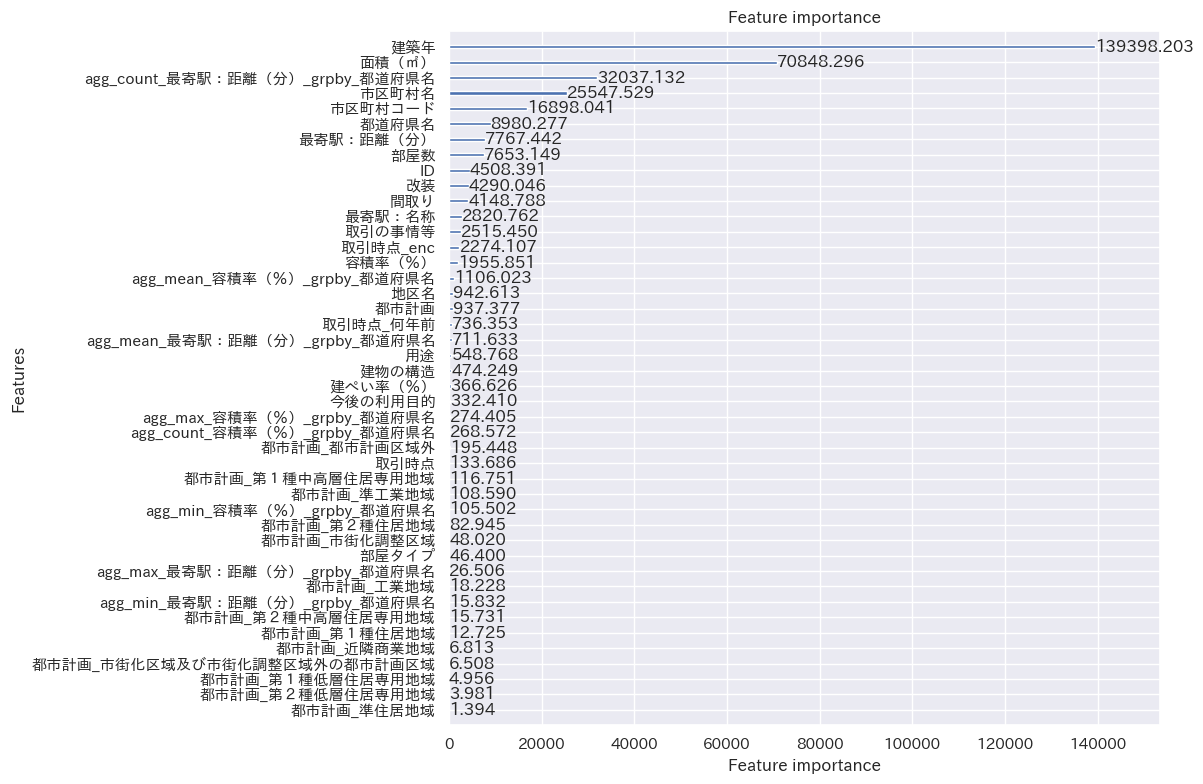

In [65]:
lgb.plot_importance(model, figsize=(12,8), max_num_features=50, importance_type='gain')
plt.tight_layout()
plt.savefig(BASE_PATH + 'output/feature_importance.png')
plt.show()
plt.close()

In [66]:
test_df[TARGET] = test_pred

/var/folders/sq/rqkt9m8947d5f6h6fxf4t9q00000gn/T/ipykernel_5793/88504142.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[TARGET] = test_pred


In [67]:
sub_df = pd.merge(sub_df[['ID']], test_df[['ID', TARGET]], on='ID')
sub_df.to_csv(BASE_PATH + 'output/test_submission.csv', index=False)